<a href="https://colab.research.google.com/github/Rajaguhan437/AI-Generation_SEGmnt/blob/main/Num_Generation/code/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### importing libs

import torch
import pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb
#%pip install wandb

import wandb
wandb.login(key="95eda70b703e651a93829d62187e30b7bc107306")

In [ ]:
exp_name = wandb.util.generate_id()

myrun = wandb.init(
    project = "Num-Gen",
    group = "MNIST-NUM",
    config = {
        "optimizer" : "adam",
        "model" : "MNIST-NumGen",
        "epoch" : "1000",
        "batch_size" : 128
        
    }
)

config = wandb.config

In [ ]:
print(exp_name)

In [ ]:
def show(tensor, ch=1, size=(28, 28), num=16, wandbactive=0, name='Image'):
    data = tensor.detach().cpu().view(-1, ch, *size) # (batch size, channels, height, width)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (num, height, width, channels)
    
    if  wandbactive==1 :
        wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})
     
    plt.imshow(grid)
    plt.show()

In [ ]:
epochs = 500
cur_step = 0
info_step = 469*5

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64

lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = "cuda"

save_steps = 235*5

wandbact = 1

dataloader = DataLoader(MNIST("/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Dataset", download=True, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)

# no. of steps = total images / batch size
# here, steps = 60000 / 256 = 234.375, took 2h 30 min for 500 epochs
# here, steps = 60000 / 128 = 468.75, took 39min for another 140 epochs



In [ ]:
def genBlock( inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)    
    )

class Genrator(nn.Module):
    def __init__(self, z_dim=64, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 , 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            genBlock(h_dim*8, h_dim*8), # 1024, 1024
            nn.Linear(h_dim*8, o_dim), # 1024, 784
            nn.Sigmoid()   
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [ ]:
## DiscBlock

def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        #nn.BatchNorm1d(out), ==> led to white block of pixels in fake imgs at starting itself.
        nn.LeakyReLU(0.2)    
    )

class Discriminator(nn.Module):
    def __init__(self, o_dim=784, h_dim=128):
      super().__init__()
      self.disc = nn.Sequential(
          discBlock(o_dim, h_dim*8), # 784 , 1024
          discBlock(h_dim*8, h_dim*4), # 1024, 512
          discBlock(h_dim*4, h_dim*2), # 512, 256
          discBlock(h_dim*2, h_dim), # 256, 128
          nn.Linear(h_dim, 1), # 128, 1
        )
        
    def forward(self, image):
        return self.disc(image)

In [ ]:
gen = Genrator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

In [ ]:
disc

In [ ]:
## Weight Initialisations

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0) 
        
#gen = gen.apply(init_weights)
#critic = critic.apply(init_weights) 

In [ ]:
## monitoring gradients and parameters in real time

if wandbact == 1:
    wandb.watch(gen, log_freq=100)
    wandb.watch(disc, log_freq=100)

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:20])
show(x)

In [ ]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    
    return gen_loss

In [ ]:
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    
    pred_fake = disc(fake.detach())
    pred_fake_targets = torch.zeros_like(pred_fake)
    pred_fake_loss = loss_func(pred_fake, pred_fake_targets)
    
    pred_real = disc(real)
    pred_real_targets = torch.ones_like(pred_real)
    pred_real_loss = loss_func(pred_real, pred_real_targets)
    
    disc_loss = (pred_real_loss + pred_fake_loss) / 2
    
    return disc_loss



In [ ]:
def save_checkpoint(name, save_path):
    
    ## Generator model
    torch.save(
        {
        'epoch' : epoch, 
        'model_state_dict' :gen.state_dict(),
        'optimizer_state_dict' : gen_opt.state_dict()
        },
        save_path+'Gen-'+name+'.pkl'
    )
    
    
    ## Discriminator Model
    torch.save(
        {
        'epoch' : epoch, 
        'model_state_dict' :disc.state_dict(),
        'optimizer_state_dict' : disc_opt.state_dict()
        }, 
        save_path+'Disc-'+name+'.pkl'
    )
    
    print("Saved Checkpoint")


In [ ]:
## Load Checkpoint

def load_checkpoint(name, load_path):
    
    ## Load Gen
    chkpt = torch.load(load_path+'Gen-'+name+'.pkl')
    gen.load_state_dict(chkpt['model_state_dict'])
    gen_opt.load_state_dict(chkpt['optimizer_state_dict'])
    
    ## Load Discriminator
    chkpt = torch.load(load_path+'Disc-'+name+'.pkl')
    disc.load_state_dict(chkpt['model_state_dict'])
    disc_opt.load_state_dict(chkpt['optimizer_state_dict'])
    
    print('Loaded Checkpoint')

In [ ]:
# Test save and load

save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

epoch = 1

save_checkpoint("test", save_path)
load_checkpoint("test", load_path)

In [ ]:
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_checkpoint("NumGEN-MNIST", load_path)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 1175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

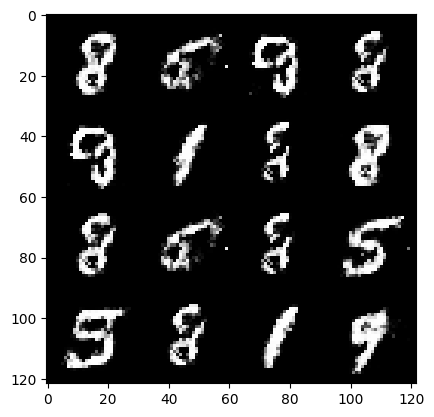

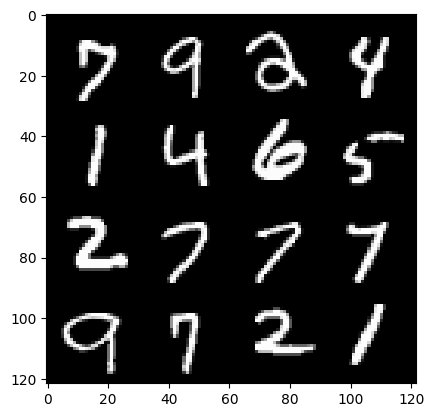

Epoch = 1011 cur_step = 2345 disc_loss = 0.29842421811844494 gen_loss = 1.9640107438000027
Saving Checkpoint: 2350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 3525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

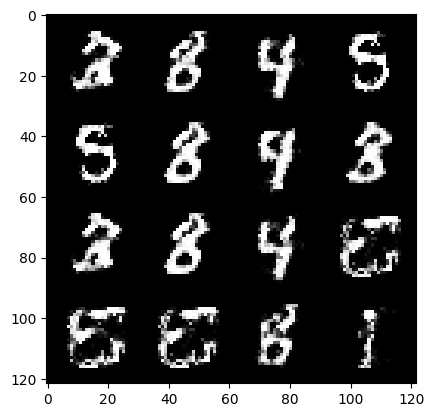

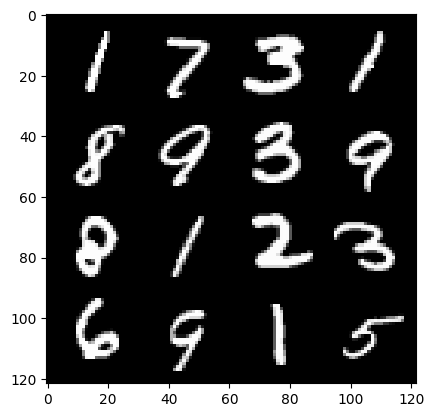

Epoch = 1016 cur_step = 4690 disc_loss = 0.2954782481640895 gen_loss = 2.0304482303448577
Saving Checkpoint: 4700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 5875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

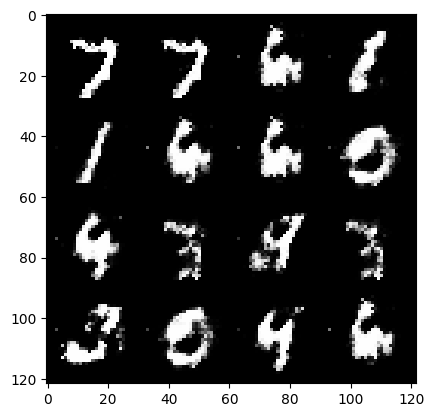

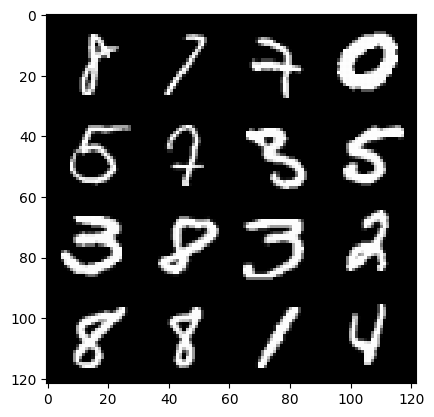

Epoch = 1021 cur_step = 7035 disc_loss = 0.36764618486229544 gen_loss = 1.7139949101120677
Saving Checkpoint: 7050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 8225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

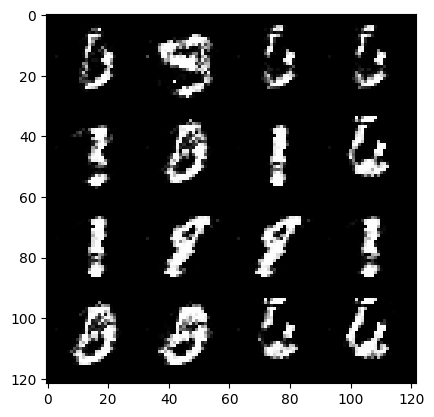

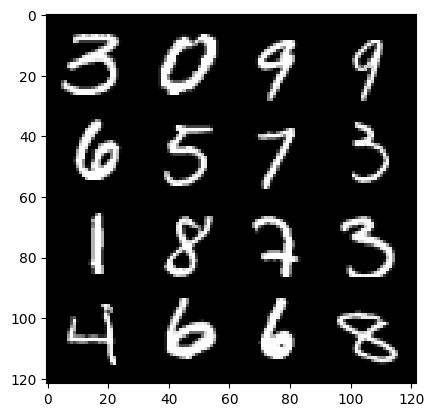

Epoch = 1026 cur_step = 9380 disc_loss = 0.38335566673832916 gen_loss = 1.6421589365391842
Saving Checkpoint: 9400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 10575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

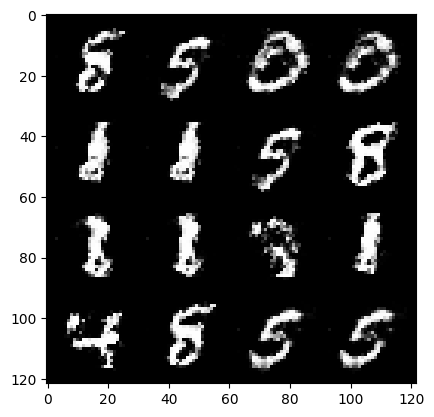

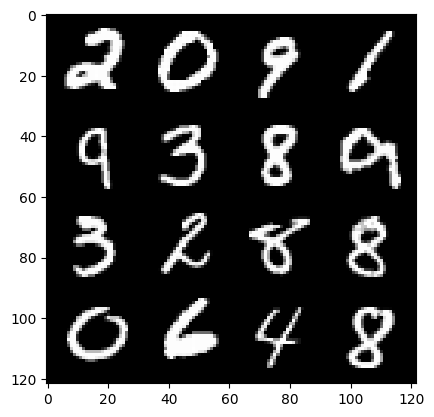

Epoch = 1031 cur_step = 11725 disc_loss = 0.279710929340391 gen_loss = 2.1100299577977357
Saving Checkpoint: 11750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 12925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

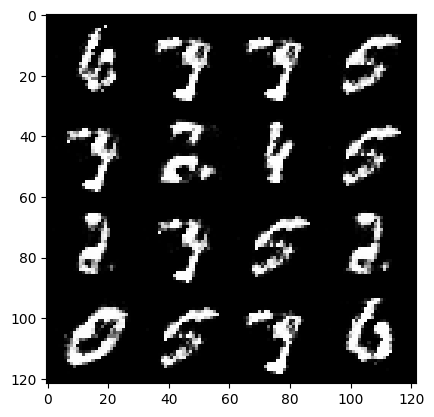

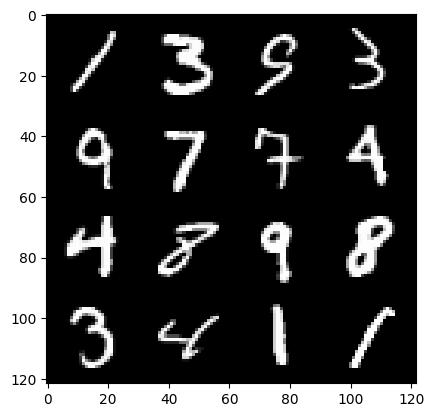

Epoch = 1036 cur_step = 14070 disc_loss = 0.3273662750400714 gen_loss = 1.8682296620248986
Saving Checkpoint: 14100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 15275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

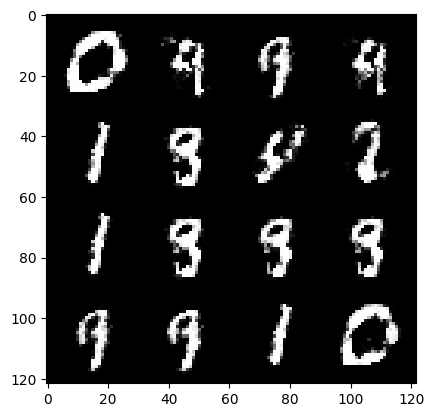

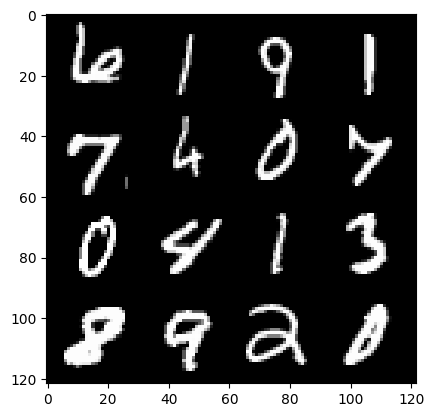

Epoch = 1041 cur_step = 16415 disc_loss = 0.29928809532732853 gen_loss = 1.977689742431966
Saving Checkpoint: 16450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 17625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

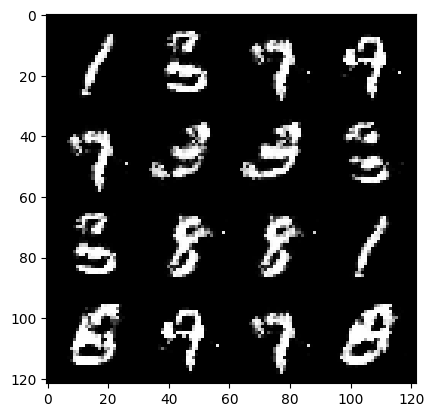

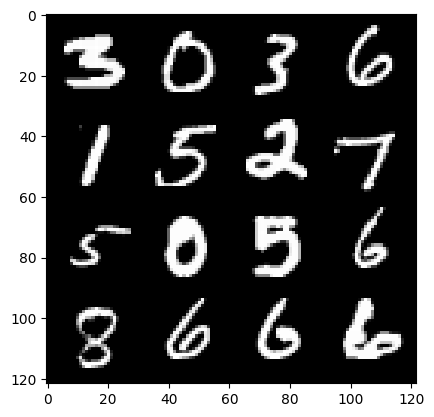

Epoch = 1046 cur_step = 18760 disc_loss = 0.3035689040414814 gen_loss = 1.9314967286103824
Saving Checkpoint: 18800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 19975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

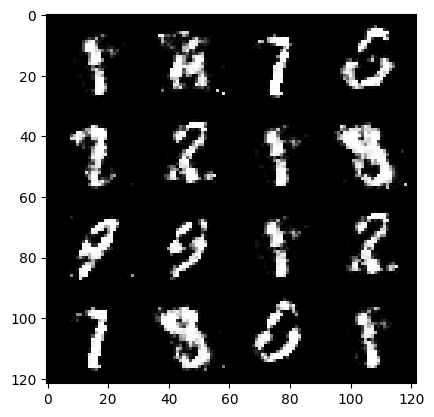

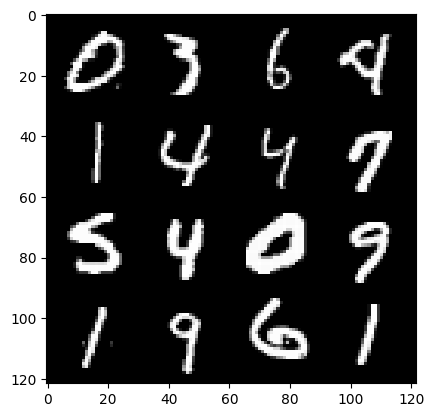

Epoch = 1051 cur_step = 21105 disc_loss = 0.3318434609723752 gen_loss = 1.870267894222284
Saving Checkpoint: 21150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 22325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

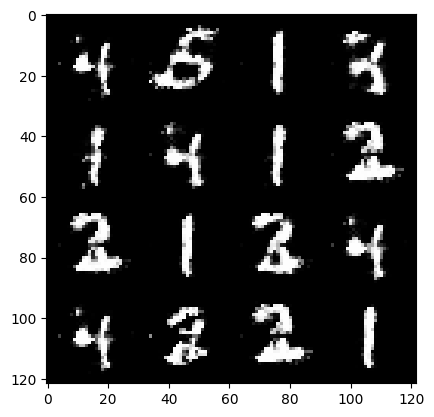

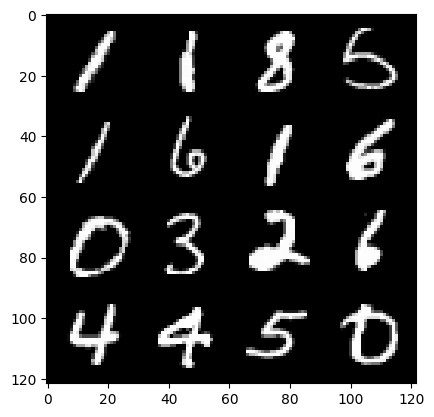

Epoch = 1056 cur_step = 23450 disc_loss = 0.34460532831739005 gen_loss = 1.7652768536417214
Saving Checkpoint: 23500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 24675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

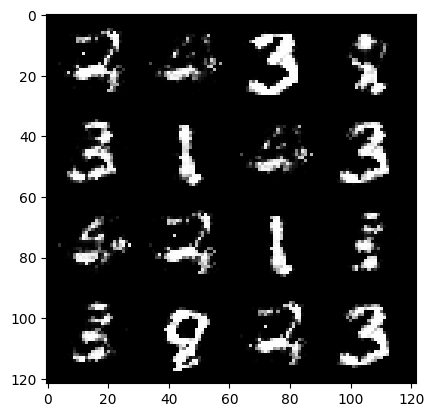

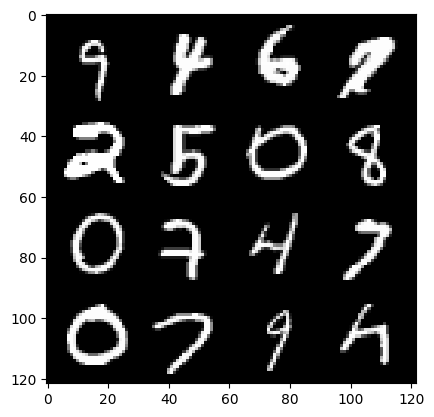

Epoch = 1061 cur_step = 25795 disc_loss = 0.3029635475579101 gen_loss = 2.0038588417110157
Saving Checkpoint: 25850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 27025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

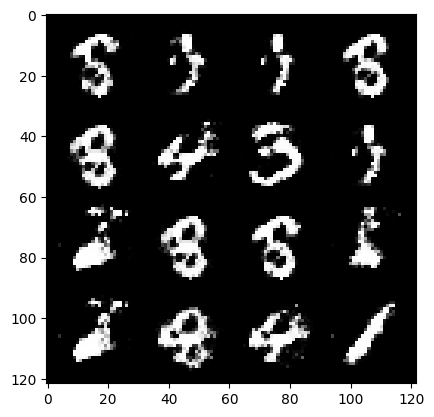

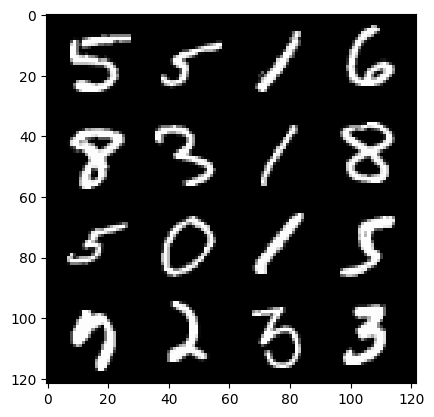

Epoch = 1066 cur_step = 28140 disc_loss = 0.265014325673265 gen_loss = 2.1474550207540677
Saving Checkpoint: 28200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 29375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

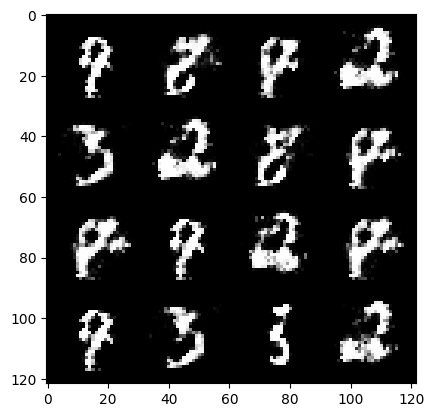

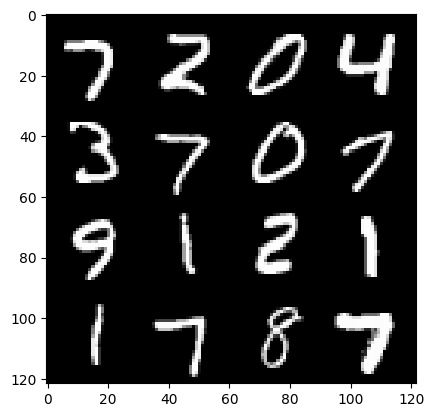

Epoch = 1071 cur_step = 30485 disc_loss = 0.2728724758190387 gen_loss = 2.071313270627817
Saving Checkpoint: 30550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 31725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

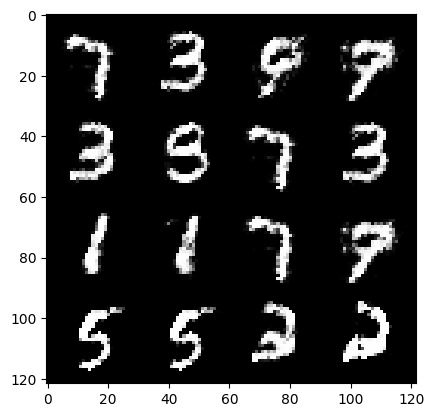

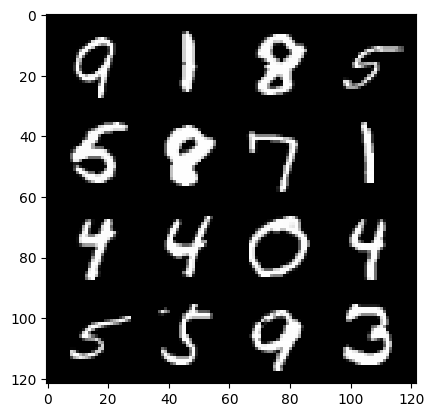

Epoch = 1076 cur_step = 32830 disc_loss = 0.2961188271800592 gen_loss = 2.025862689008082
Saving Checkpoint: 32900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 34075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

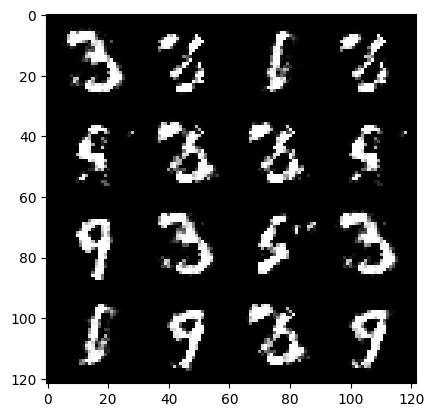

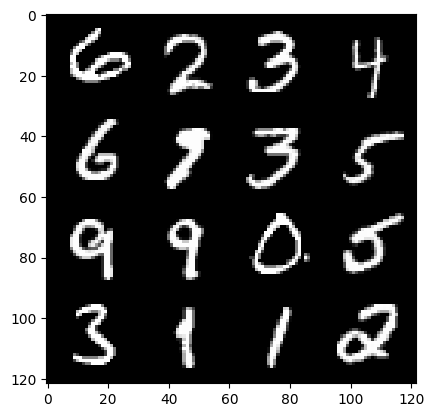

Epoch = 1081 cur_step = 35175 disc_loss = 0.30687857179372297 gen_loss = 1.9583262584356864
Saving Checkpoint: 35250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 36425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

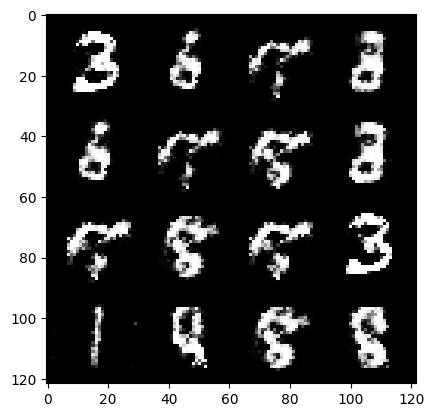

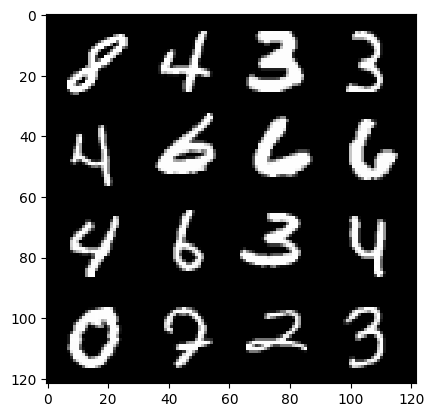

Epoch = 1086 cur_step = 37520 disc_loss = 0.2798836019184035 gen_loss = 2.0500101020341233
Saving Checkpoint: 37600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 38775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

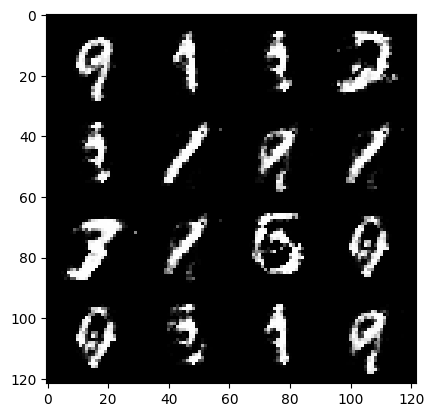

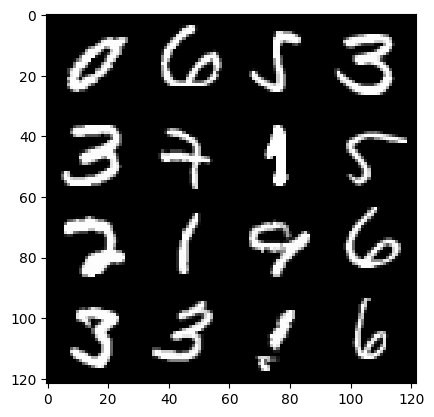

Epoch = 1091 cur_step = 39865 disc_loss = 0.31240371798020183 gen_loss = 1.9065093774022832
Saving Checkpoint: 39950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 41125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

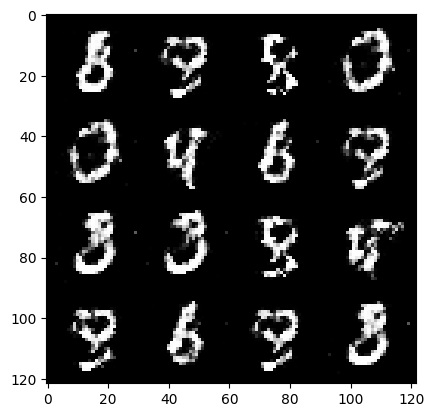

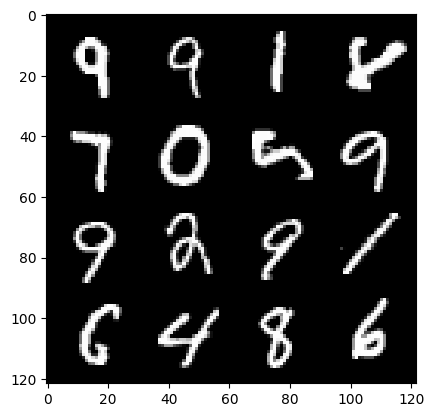

Epoch = 1096 cur_step = 42210 disc_loss = 0.28452975729635277 gen_loss = 2.0534073896245406
Saving Checkpoint: 42300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 43475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

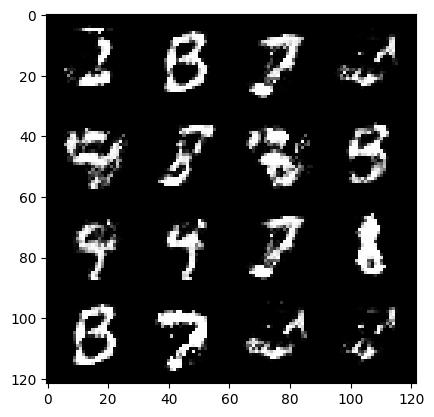

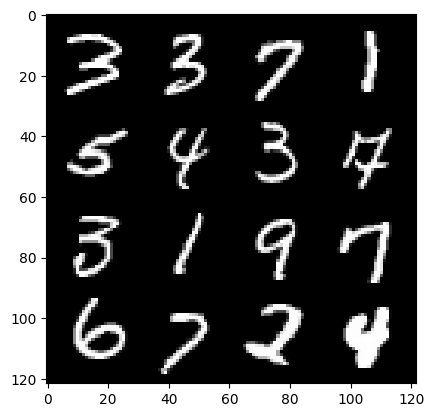

Epoch = 1101 cur_step = 44555 disc_loss = 0.2895697209054727 gen_loss = 1.9908290614959783
Saving Checkpoint: 44650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 45825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

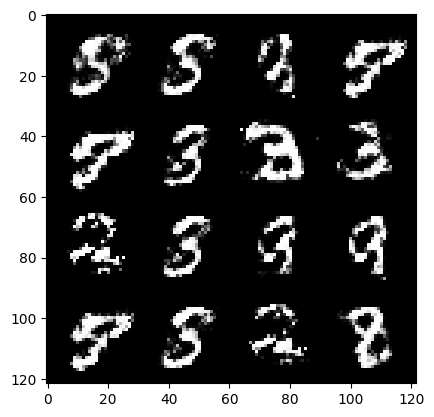

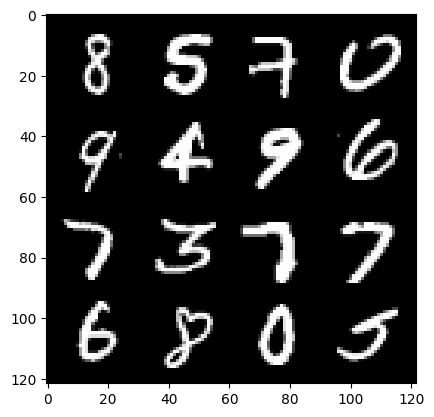

Epoch = 1106 cur_step = 46900 disc_loss = 0.3001542023313579 gen_loss = 2.0193301602975646
Saving Checkpoint: 47000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 48175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

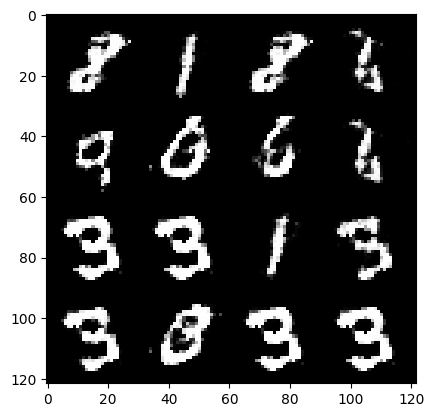

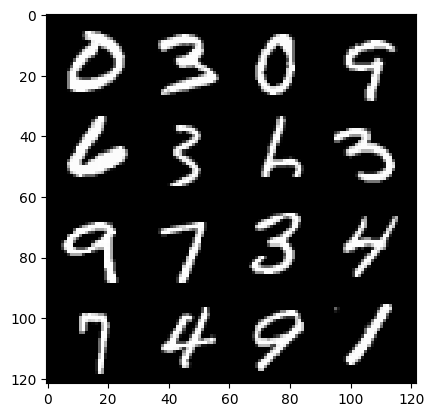

Epoch = 1111 cur_step = 49245 disc_loss = 0.2966622077135135 gen_loss = 2.032138579791543
Saving Checkpoint: 49350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 50525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

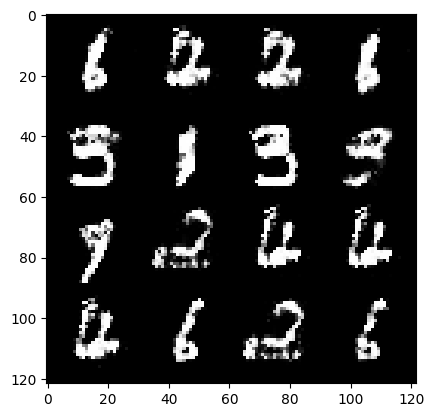

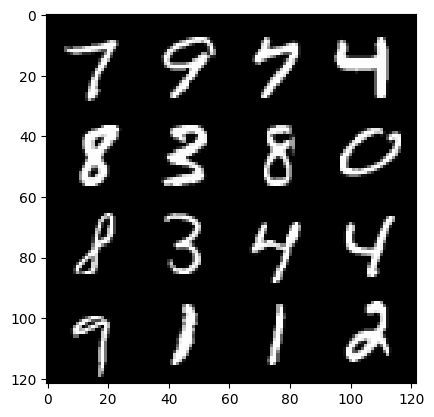

Epoch = 1116 cur_step = 51590 disc_loss = 0.30519107458815137 gen_loss = 1.9176299821593359
Saving Checkpoint: 51700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 52875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

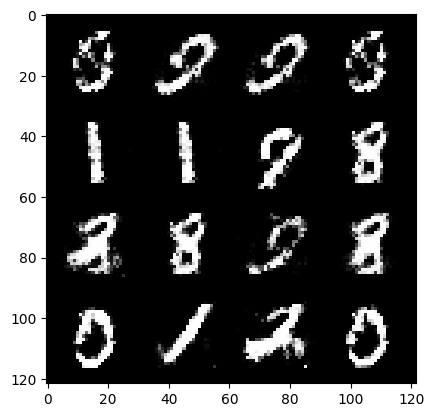

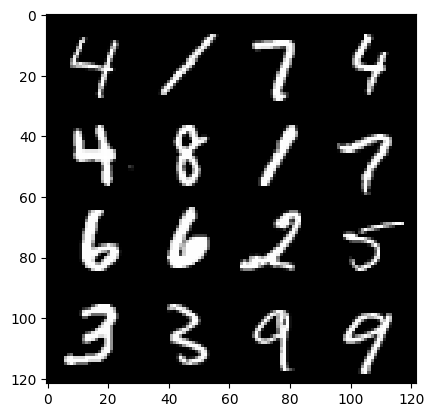

Epoch = 1121 cur_step = 53935 disc_loss = 0.31734188079579806 gen_loss = 1.8790466162695814
Saving Checkpoint: 54050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 55225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

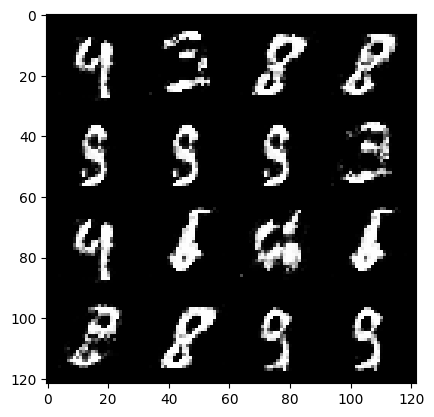

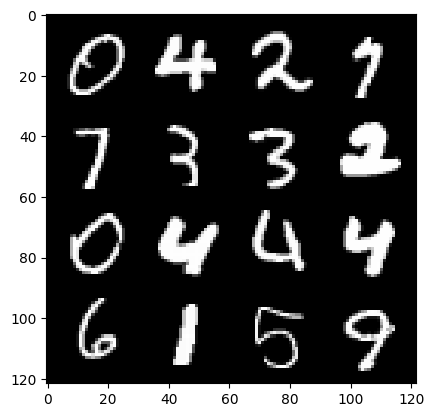

Epoch = 1126 cur_step = 56280 disc_loss = 0.3088638566069003 gen_loss = 1.9660248448853808
Saving Checkpoint: 56400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 57575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

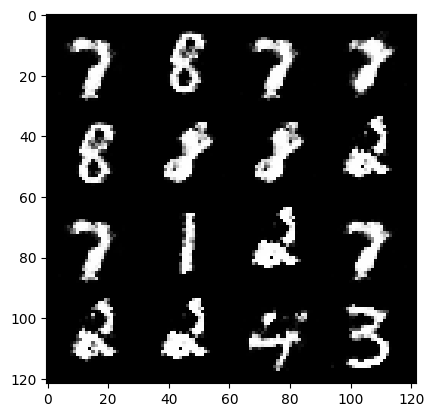

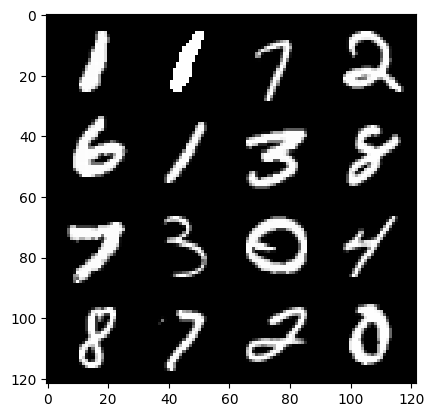

Epoch = 1131 cur_step = 58625 disc_loss = 0.30274450967052596 gen_loss = 2.002273963305996
Saving Checkpoint: 58750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 59925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

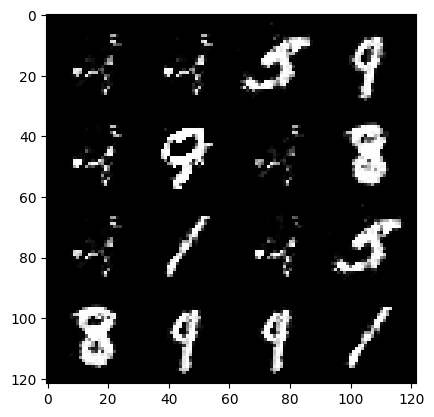

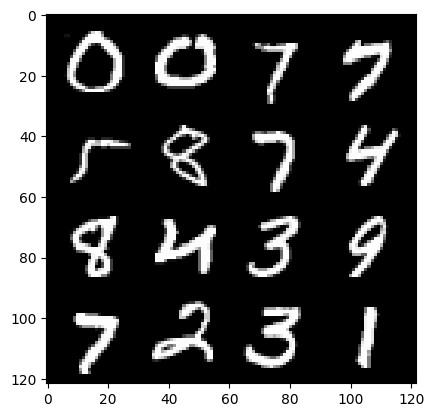

Epoch = 1136 cur_step = 60970 disc_loss = 0.2957775163307373 gen_loss = 1.9593023514696783
Saving Checkpoint: 61100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 62275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

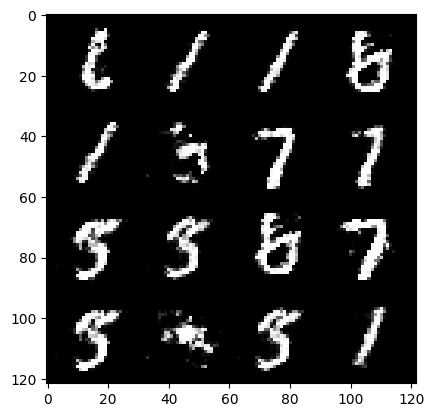

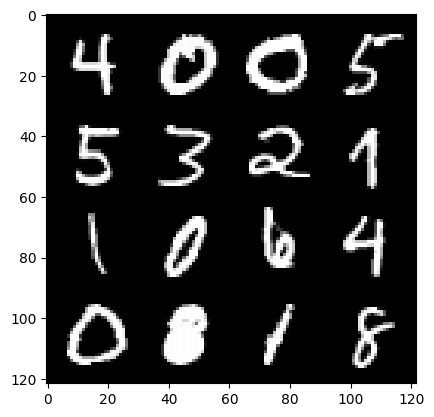

Epoch = 1141 cur_step = 63315 disc_loss = 0.28492052694881903 gen_loss = 2.0376249867969993
Saving Checkpoint: 63450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 64625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

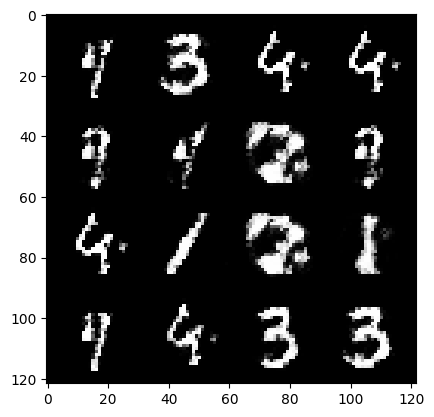

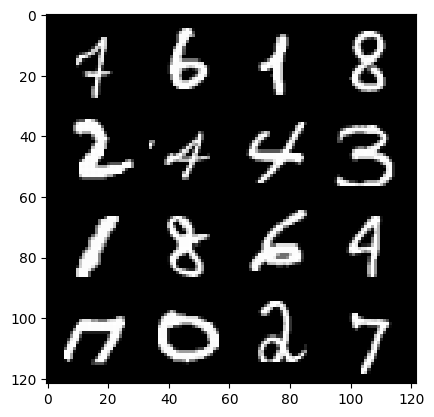

Epoch = 1146 cur_step = 65660 disc_loss = 0.2877391672274197 gen_loss = 1.982042273021202
Saving Checkpoint: 65800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 66975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

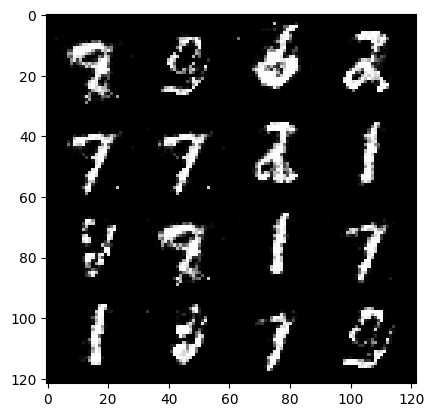

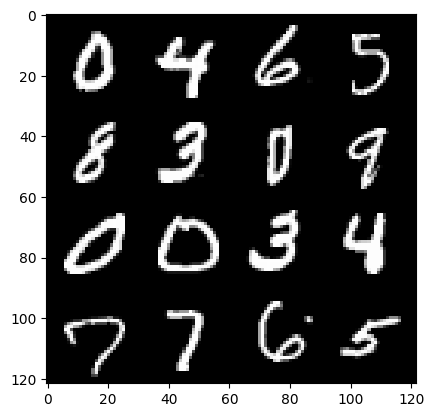

Epoch = 1151 cur_step = 68005 disc_loss = 0.32046598684050637 gen_loss = 1.8920759842594042
Saving Checkpoint: 68150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 69325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

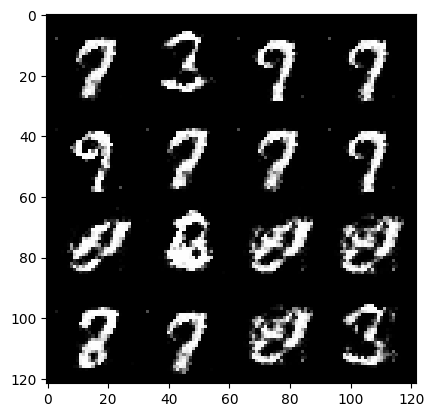

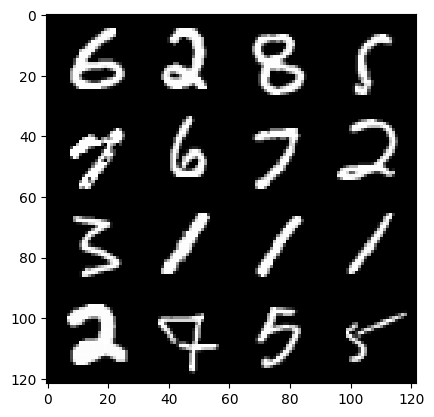

Epoch = 1156 cur_step = 70350 disc_loss = 0.3228213908385112 gen_loss = 1.896312702439233
Saving Checkpoint: 70500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 71675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

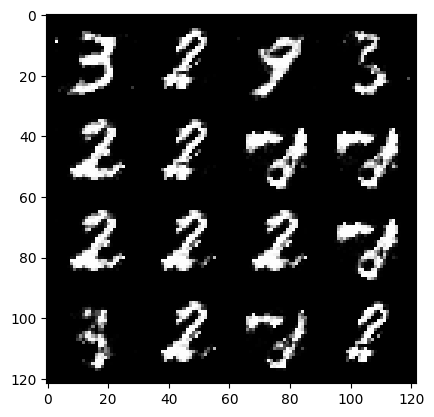

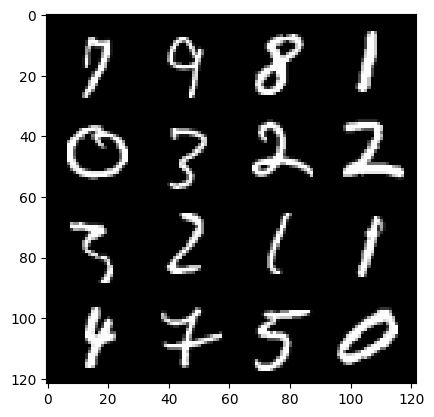

Epoch = 1161 cur_step = 72695 disc_loss = 0.292487464187496 gen_loss = 2.011365791882025
Saving Checkpoint: 72850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 74025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

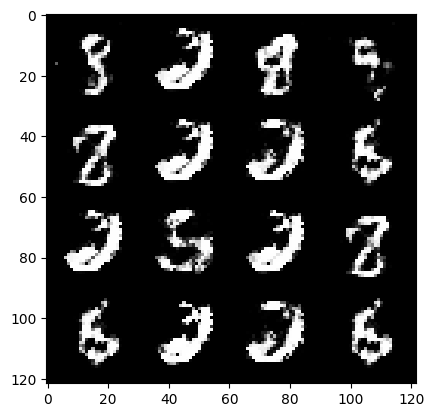

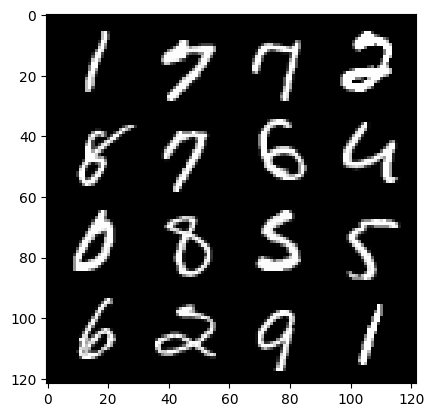

Epoch = 1166 cur_step = 75040 disc_loss = 0.295135758038777 gen_loss = 2.026492979785781
Saving Checkpoint: 75200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 76375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

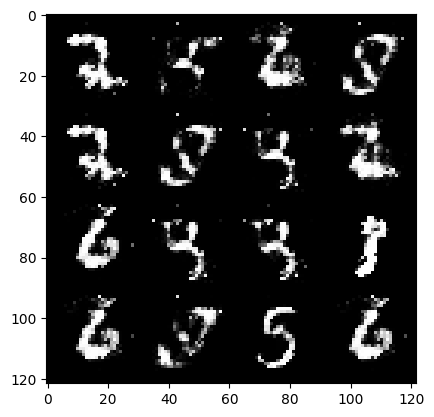

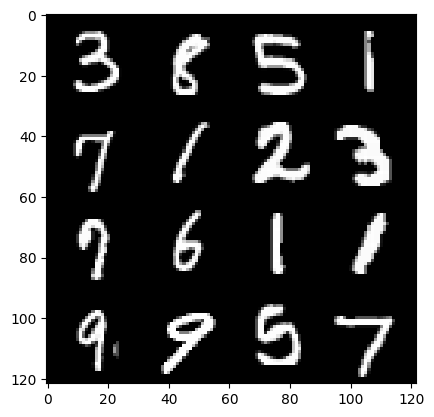

Epoch = 1171 cur_step = 77385 disc_loss = 0.2702768114425226 gen_loss = 2.1100810889242045
Saving Checkpoint: 77550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 78725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

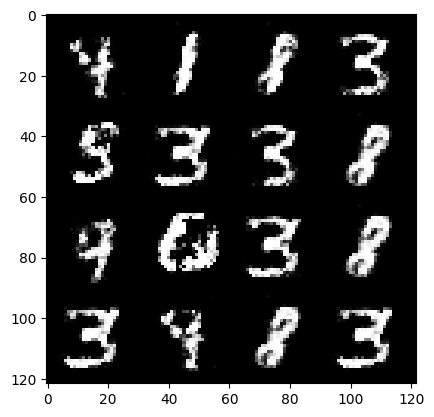

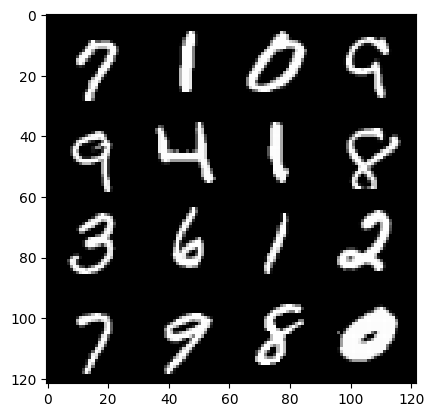

Epoch = 1176 cur_step = 79730 disc_loss = 0.2980506743640025 gen_loss = 2.0466918412047916
Saving Checkpoint: 79900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 81075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

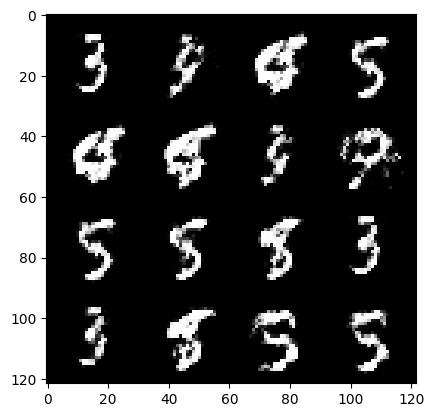

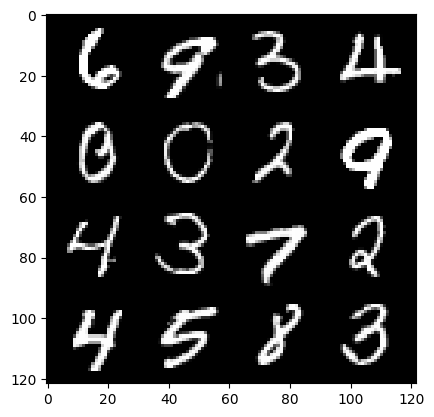

Epoch = 1181 cur_step = 82075 disc_loss = 0.29278679786841755 gen_loss = 1.9759106758560963
Saving Checkpoint: 82250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 83425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

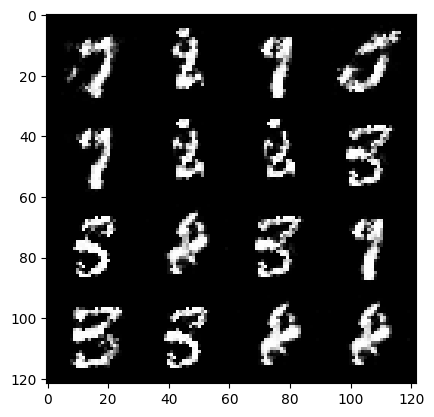

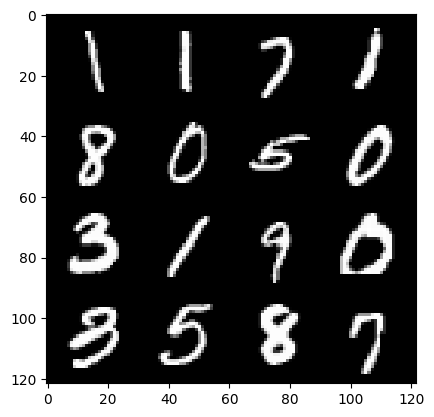

Epoch = 1186 cur_step = 84420 disc_loss = 0.2760564333785063 gen_loss = 2.1271390827479904
Saving Checkpoint: 84600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 85775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

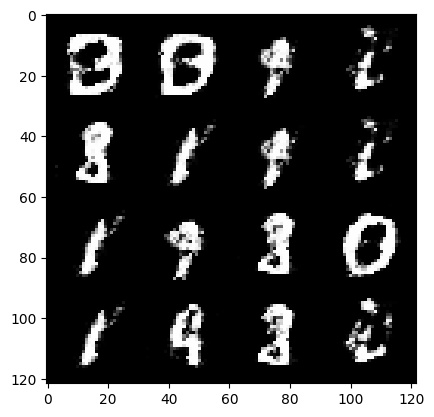

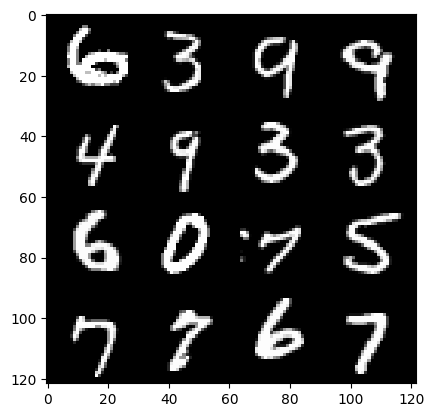

Epoch = 1191 cur_step = 86765 disc_loss = 0.27003415112874146 gen_loss = 2.146880536801271
Saving Checkpoint: 86950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 88125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

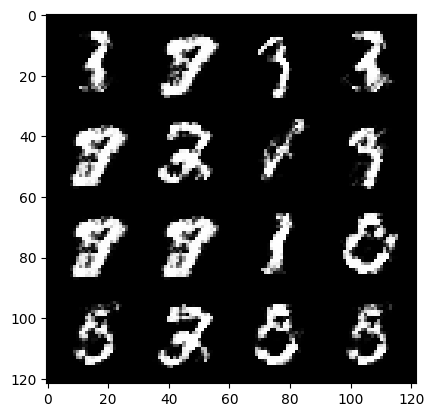

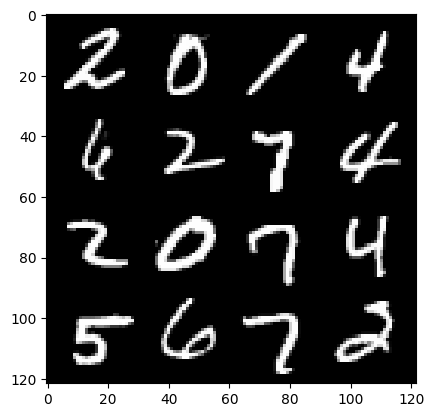

Epoch = 1196 cur_step = 89110 disc_loss = 0.3064185826064173 gen_loss = 1.9498573476063417
Saving Checkpoint: 89300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 90475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

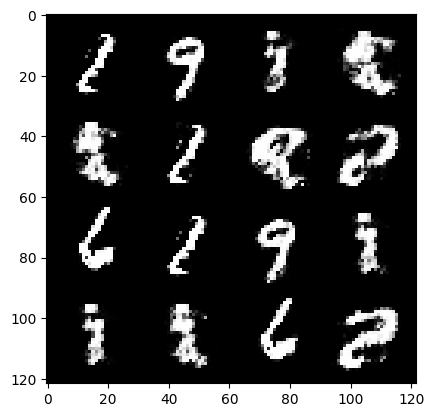

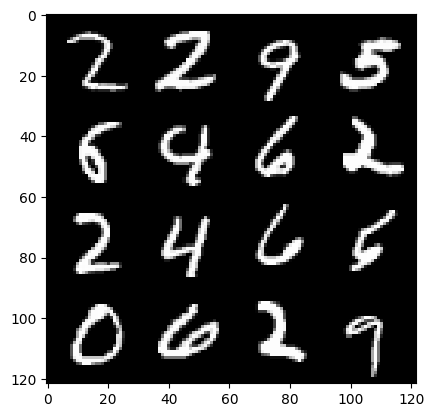

Epoch = 1201 cur_step = 91455 disc_loss = 0.3220205189386156 gen_loss = 1.8716348514882233
Saving Checkpoint: 91650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 92825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

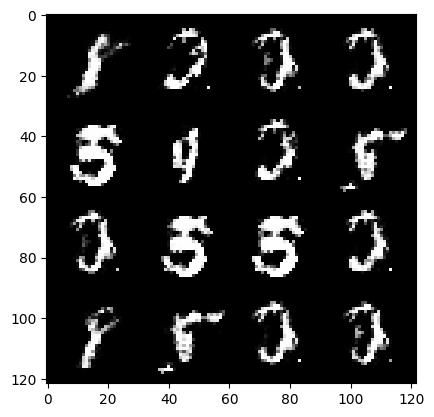

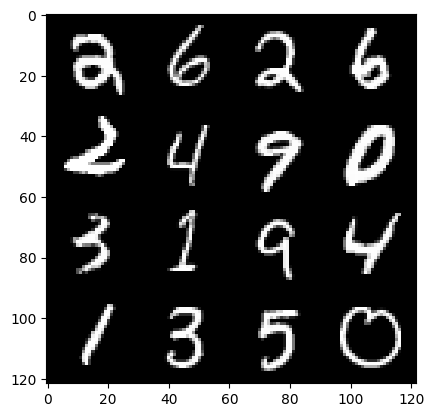

Epoch = 1206 cur_step = 93800 disc_loss = 0.30434556766740806 gen_loss = 1.9297609511723142
Saving Checkpoint: 94000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 95175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

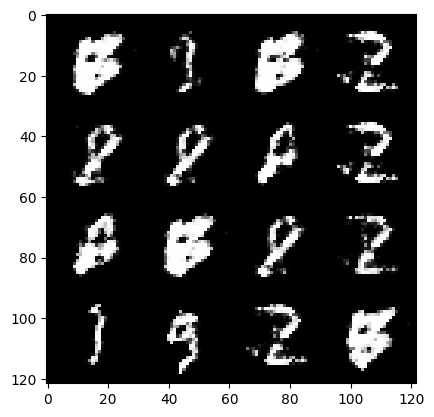

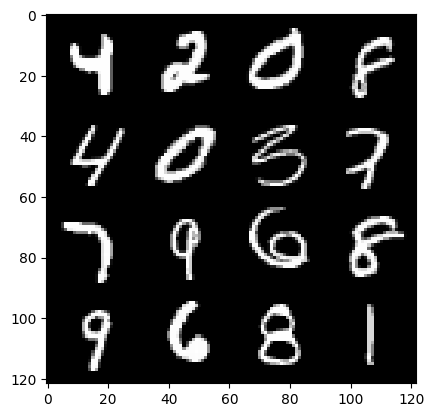

Epoch = 1211 cur_step = 96145 disc_loss = 0.27625314900870007 gen_loss = 2.0784426658138284
Saving Checkpoint: 96350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 97525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

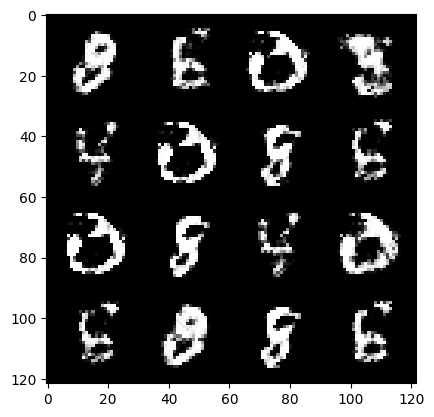

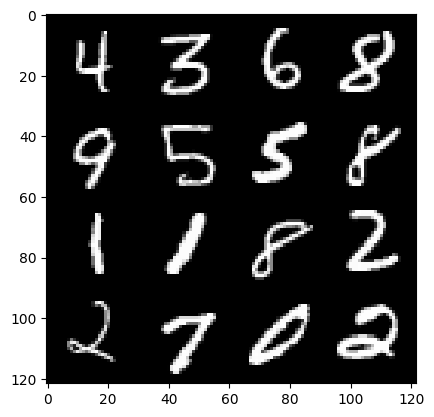

Epoch = 1216 cur_step = 98490 disc_loss = 0.28013562015505994 gen_loss = 2.099699214526585
Saving Checkpoint: 98700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 99875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

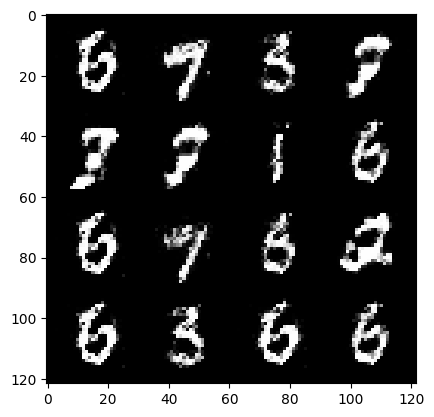

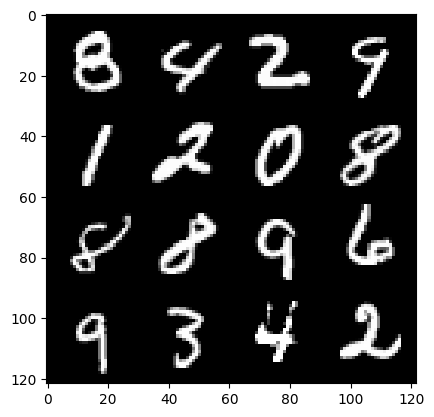

Epoch = 1221 cur_step = 100835 disc_loss = 0.27969277631372275 gen_loss = 2.0818798757056944
Saving Checkpoint: 101050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 102225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

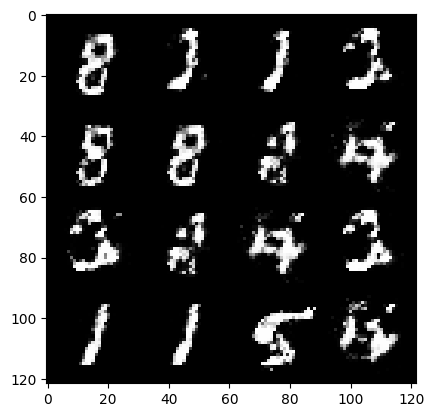

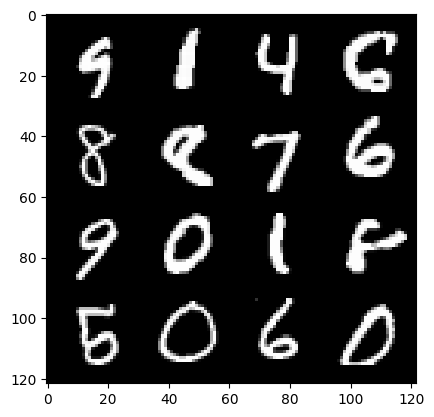

Epoch = 1226 cur_step = 103180 disc_loss = 0.28526472118871804 gen_loss = 1.9597408563597625
Saving Checkpoint: 103400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 104575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

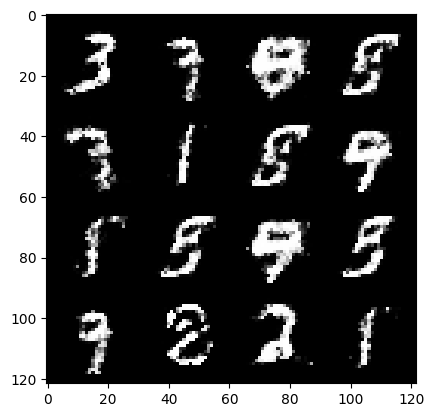

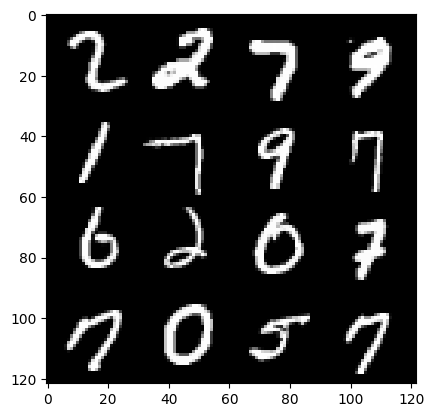

Epoch = 1231 cur_step = 105525 disc_loss = 0.31546480505069946 gen_loss = 1.902666635757316
Saving Checkpoint: 105750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 106925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

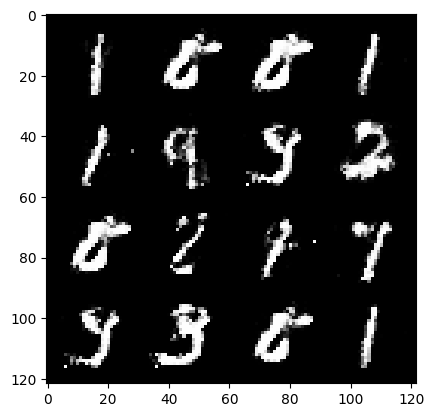

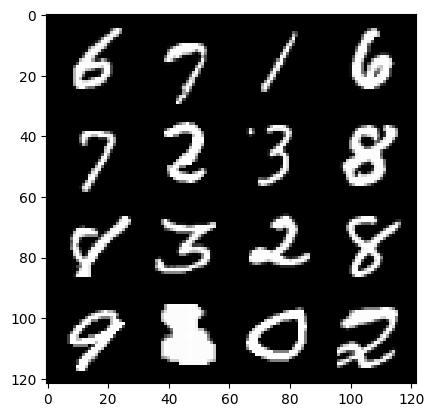

Epoch = 1236 cur_step = 107870 disc_loss = 0.3486415194550049 gen_loss = 1.7750843116215298
Saving Checkpoint: 108100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 109275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

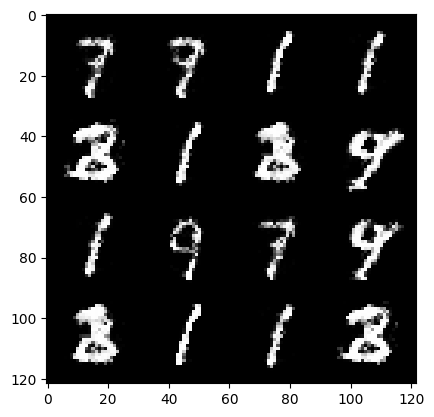

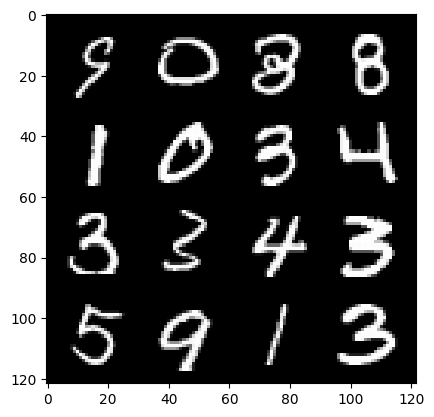

Epoch = 1241 cur_step = 110215 disc_loss = 0.3349365072336787 gen_loss = 1.798685754336782
Saving Checkpoint: 110450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 111625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

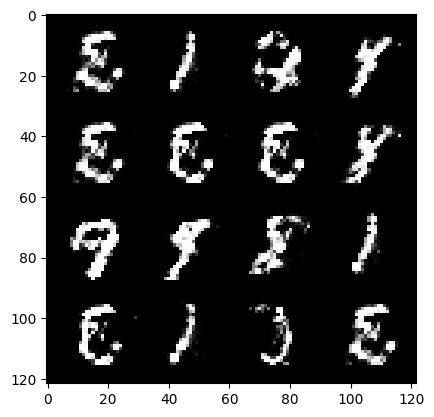

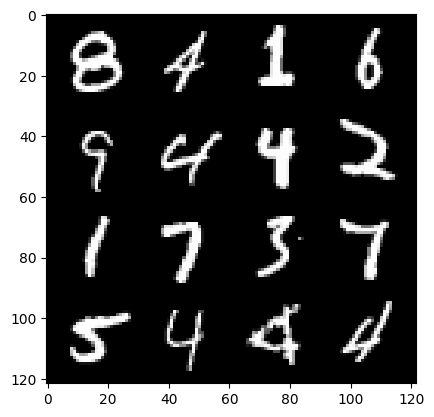

Epoch = 1246 cur_step = 112560 disc_loss = 0.3178384699483416 gen_loss = 1.8728264896091875
Saving Checkpoint: 112800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 113975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

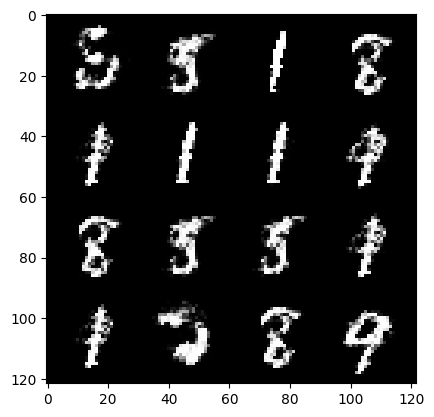

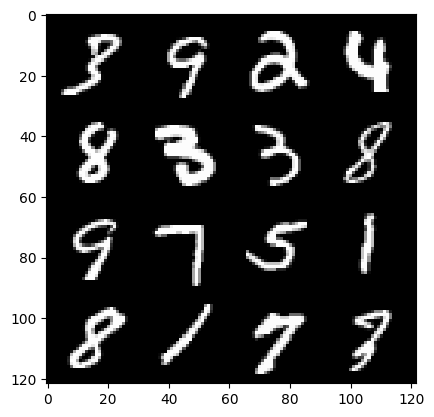

Epoch = 1251 cur_step = 114905 disc_loss = 0.29843088903152615 gen_loss = 1.942337525170495
Saving Checkpoint: 115150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 116325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

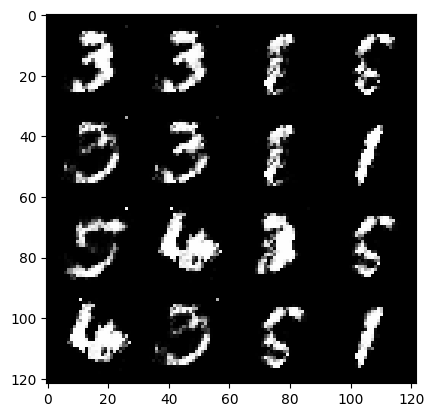

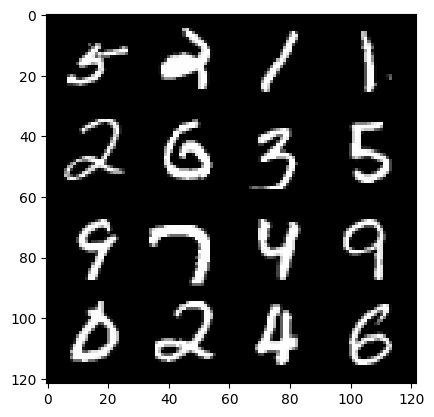

Epoch = 1256 cur_step = 117250 disc_loss = 0.3093338090791377 gen_loss = 1.9320722507261263
Saving Checkpoint: 117500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 118675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

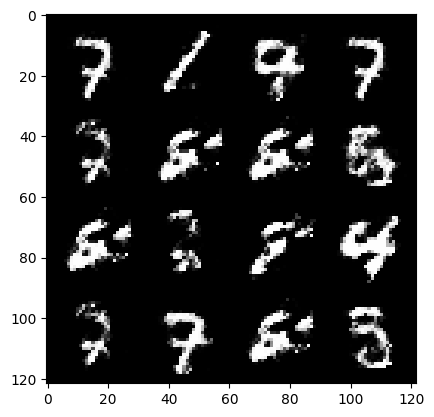

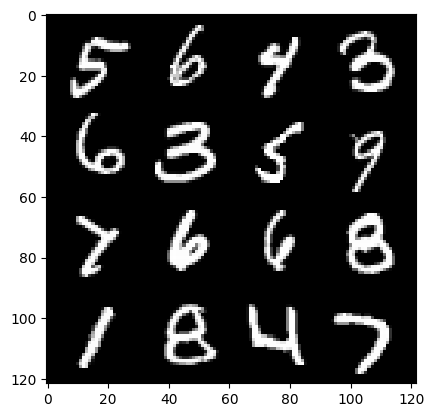

Epoch = 1261 cur_step = 119595 disc_loss = 0.3148943829193298 gen_loss = 1.9377918967305978
Saving Checkpoint: 119850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 121025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

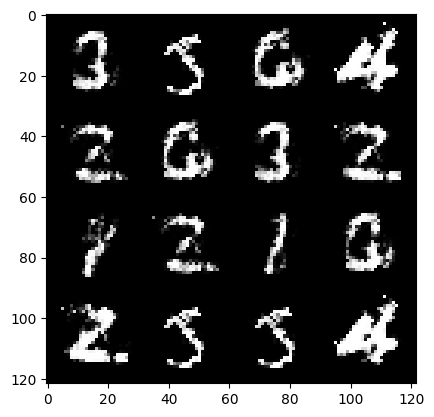

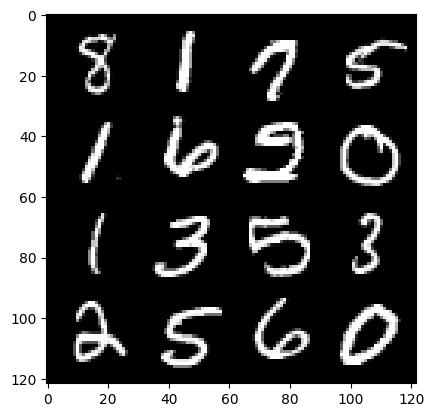

Epoch = 1266 cur_step = 121940 disc_loss = 0.3301100725431178 gen_loss = 1.8599845770325487
Saving Checkpoint: 122200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 123375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

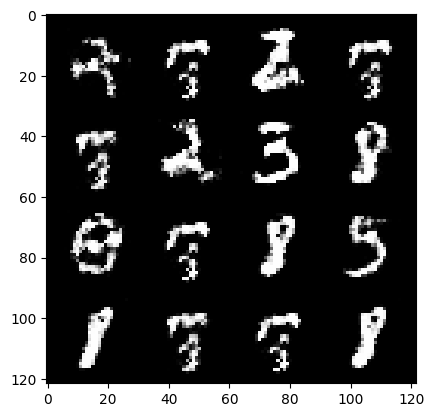

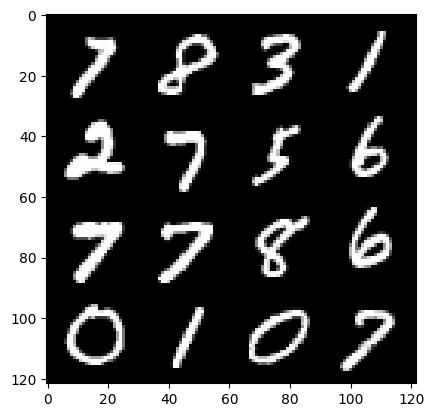

Epoch = 1271 cur_step = 124285 disc_loss = 0.3235297754692879 gen_loss = 1.877337523208244
Saving Checkpoint: 124550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 125725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

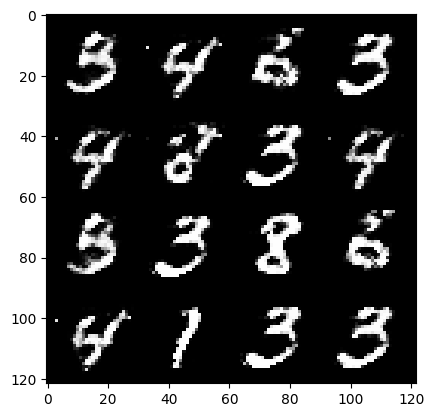

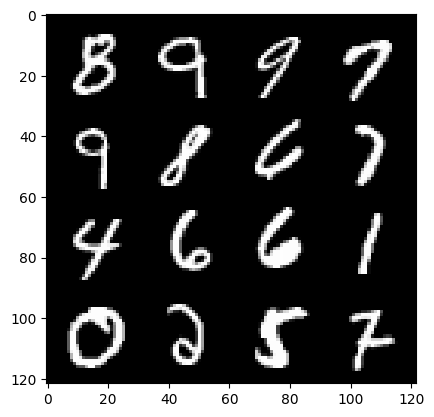

Epoch = 1276 cur_step = 126630 disc_loss = 0.300535363781808 gen_loss = 1.9972681692160015
Saving Checkpoint: 126900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 128075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

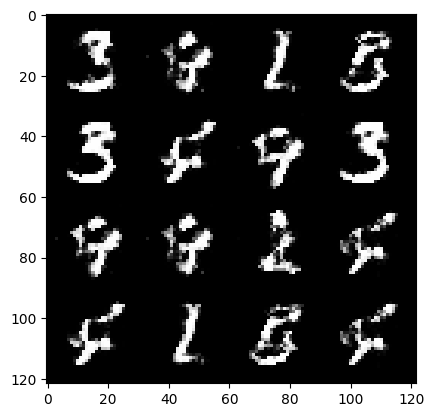

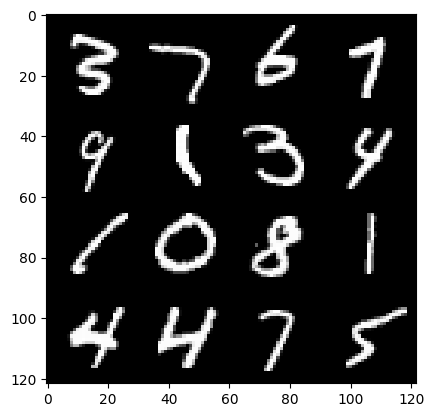

Epoch = 1281 cur_step = 128975 disc_loss = 0.3214587361128854 gen_loss = 1.893931078554979
Saving Checkpoint: 129250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 130425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

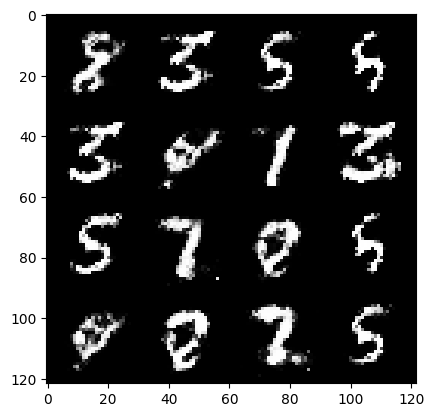

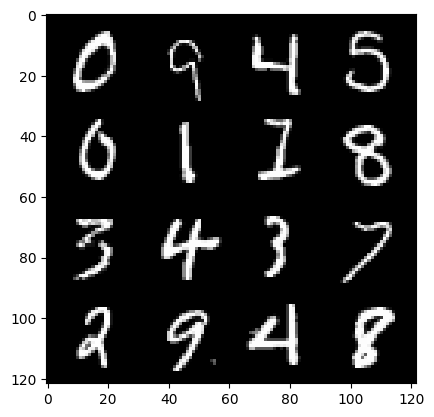

Epoch = 1286 cur_step = 131320 disc_loss = 0.3166896655806092 gen_loss = 1.9231191847115945
Saving Checkpoint: 131600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 132775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

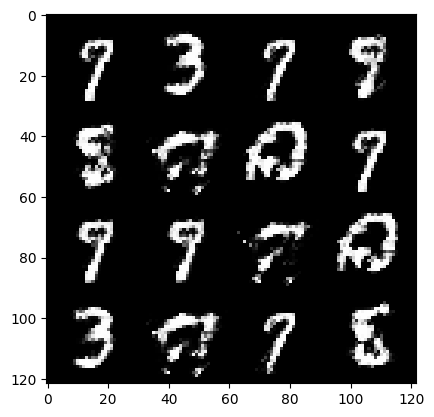

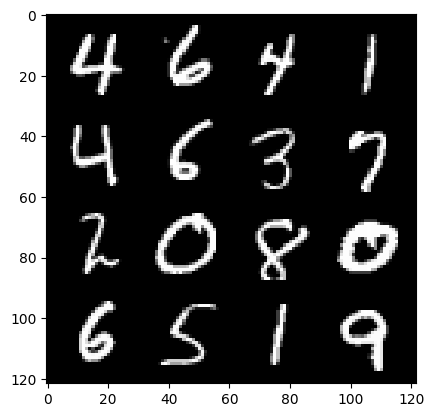

Epoch = 1291 cur_step = 133665 disc_loss = 0.3086886772723086 gen_loss = 1.9282468681904807
Saving Checkpoint: 133950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 135125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

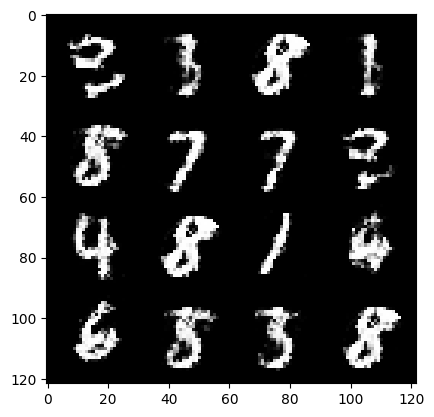

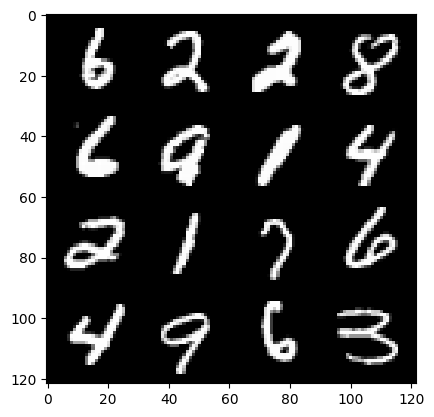

Epoch = 1296 cur_step = 136010 disc_loss = 0.30543459851477445 gen_loss = 1.9072484541549357
Saving Checkpoint: 136300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 137475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

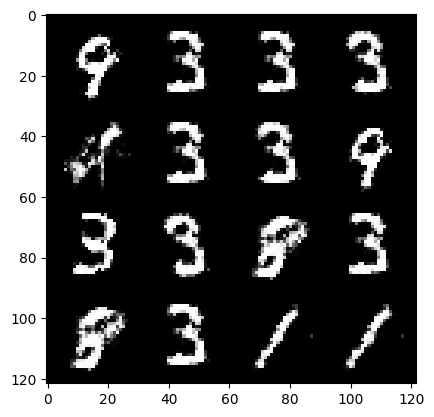

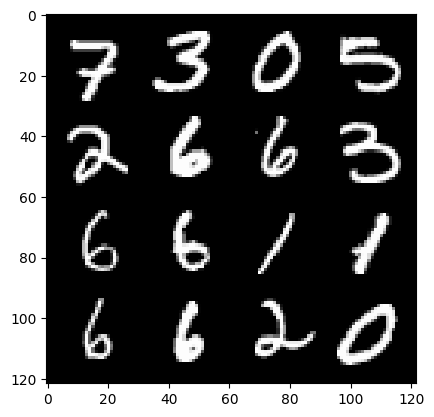

Epoch = 1301 cur_step = 138355 disc_loss = 0.3236455391210788 gen_loss = 1.8896753713266174
Saving Checkpoint: 138650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 139825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

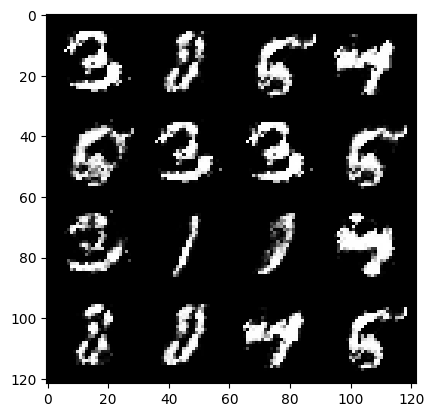

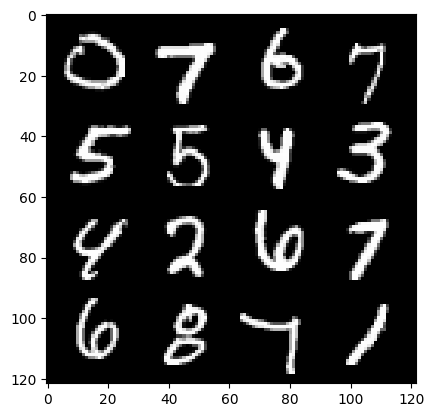

Epoch = 1306 cur_step = 140700 disc_loss = 0.3014122555695617 gen_loss = 1.9589547130853129
Saving Checkpoint: 141000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 142175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

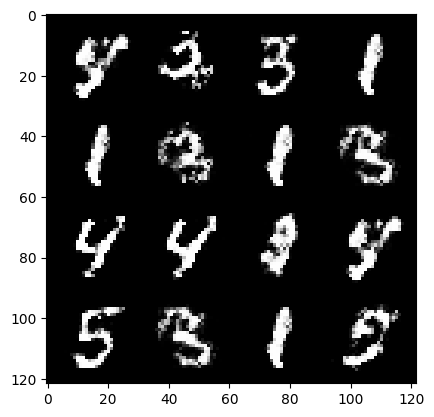

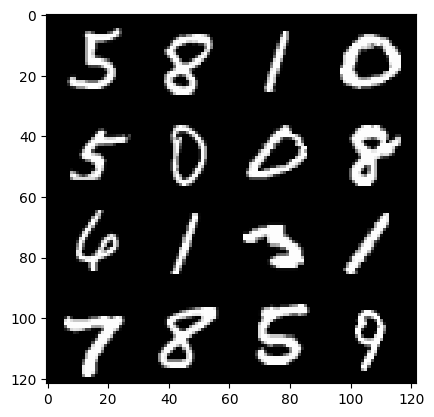

Epoch = 1311 cur_step = 143045 disc_loss = 0.31797353240218496 gen_loss = 1.913002392020561
Saving Checkpoint: 143350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 144525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

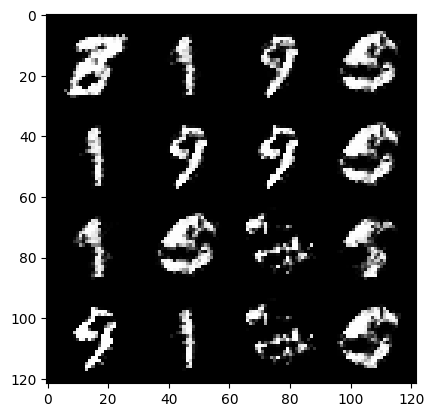

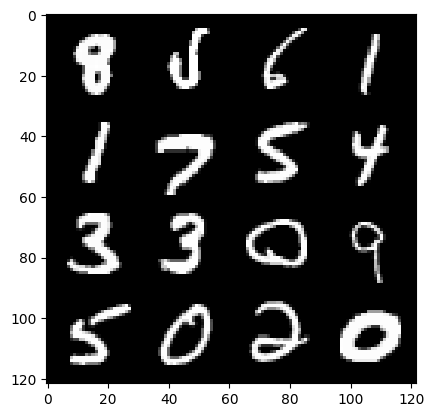

Epoch = 1316 cur_step = 145390 disc_loss = 0.33377570032056714 gen_loss = 1.8510487451736353
Saving Checkpoint: 145700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 146875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

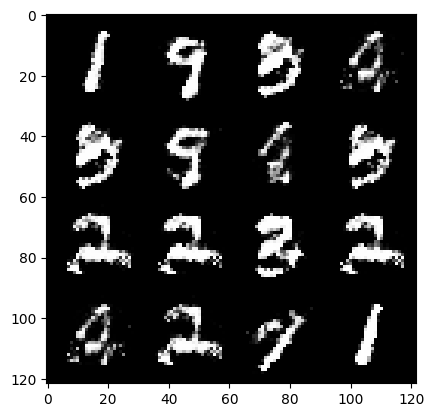

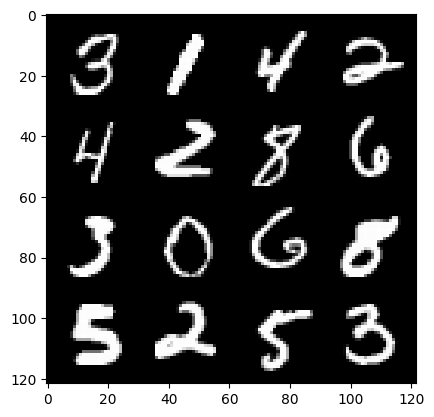

Epoch = 1321 cur_step = 147735 disc_loss = 0.3210709509437781 gen_loss = 1.858557341297044
Saving Checkpoint: 148050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 149225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

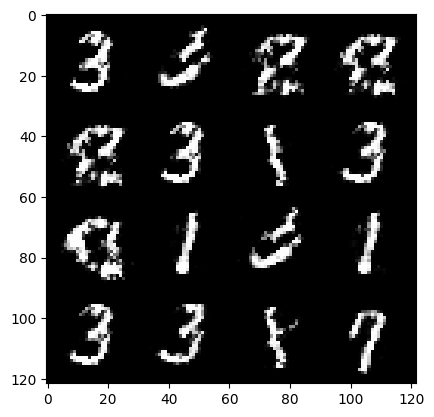

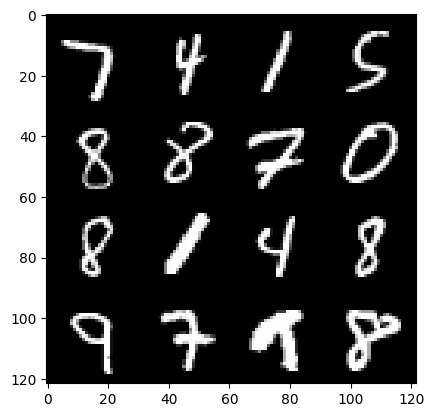

Epoch = 1326 cur_step = 150080 disc_loss = 0.32367703725915475 gen_loss = 1.8304014696495365
Saving Checkpoint: 150400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 151575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

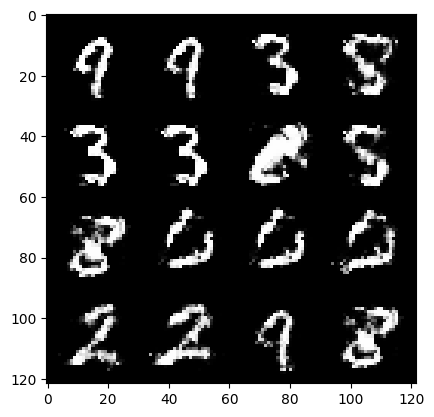

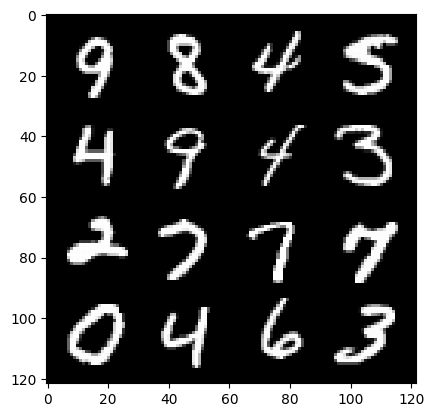

Epoch = 1331 cur_step = 152425 disc_loss = 0.29150819262144156 gen_loss = 2.0483827880704837
Saving Checkpoint: 152750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 153925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

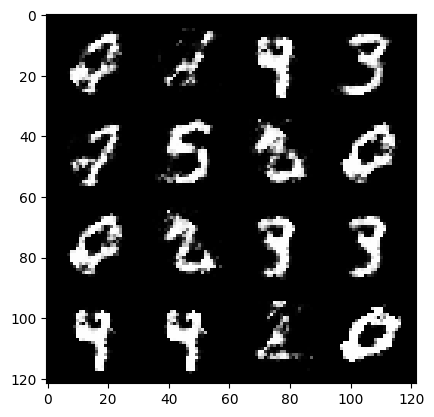

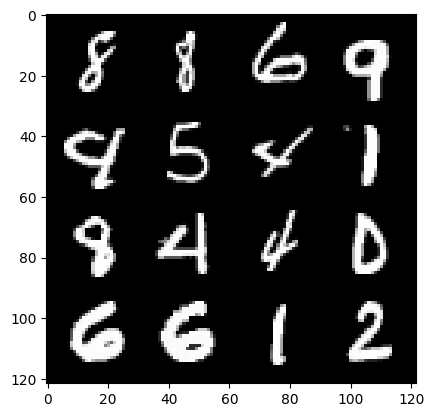

Epoch = 1336 cur_step = 154770 disc_loss = 0.3246967066262068 gen_loss = 1.8637948172433036
Saving Checkpoint: 155100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 156275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

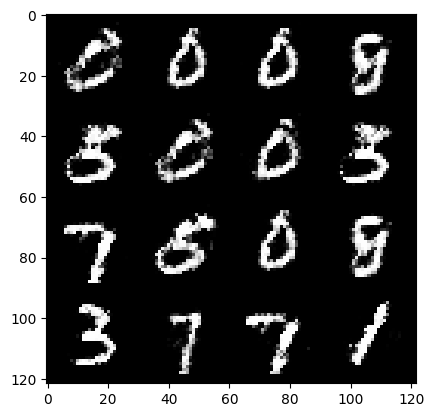

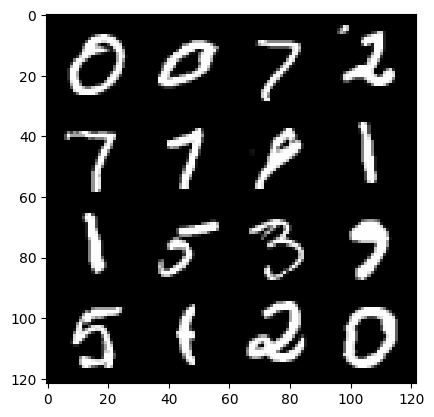

Epoch = 1341 cur_step = 157115 disc_loss = 0.3029115173036356 gen_loss = 1.9470856077381289
Saving Checkpoint: 157450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 158625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

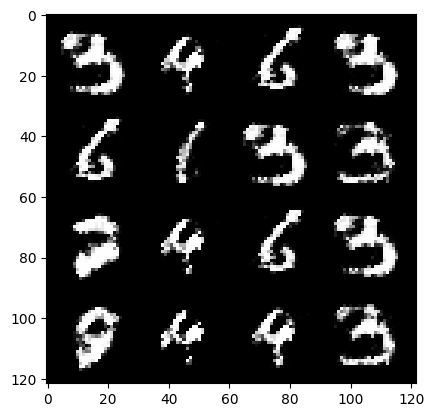

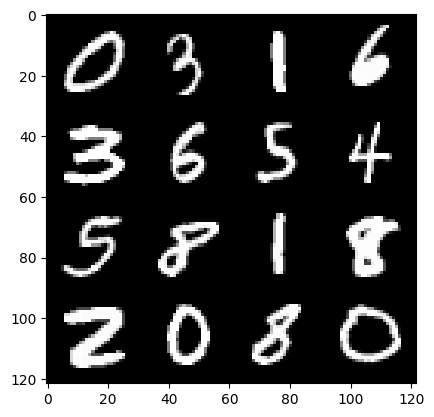

Epoch = 1346 cur_step = 159460 disc_loss = 0.30960257814954845 gen_loss = 1.9375484152897589
Saving Checkpoint: 159800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 160975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

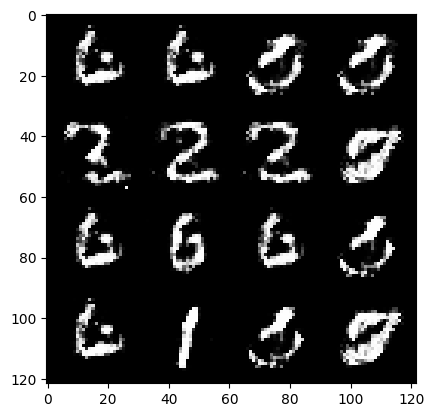

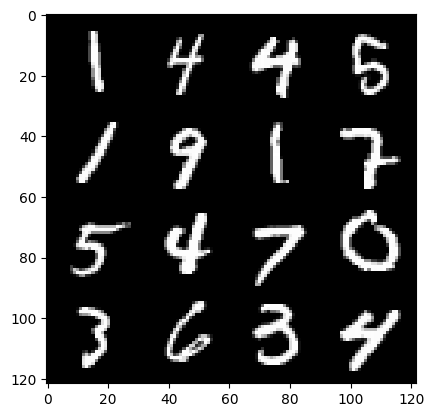

Epoch = 1351 cur_step = 161805 disc_loss = 0.33143364818873944 gen_loss = 1.8256139279936932
Saving Checkpoint: 162150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 163325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

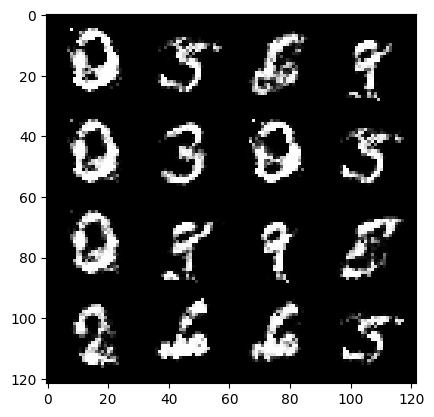

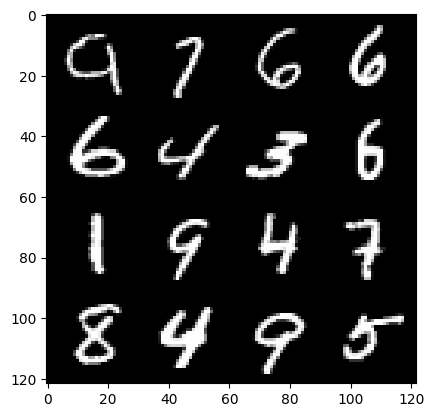

Epoch = 1356 cur_step = 164150 disc_loss = 0.31533410024287095 gen_loss = 1.8804514832079793
Saving Checkpoint: 164500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 165675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

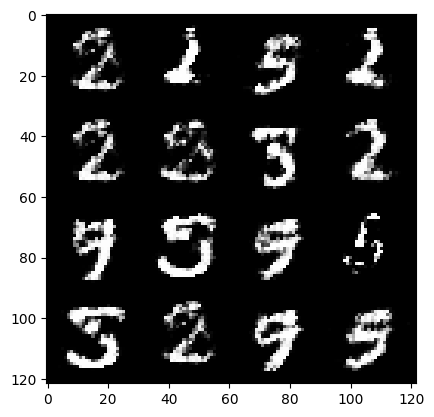

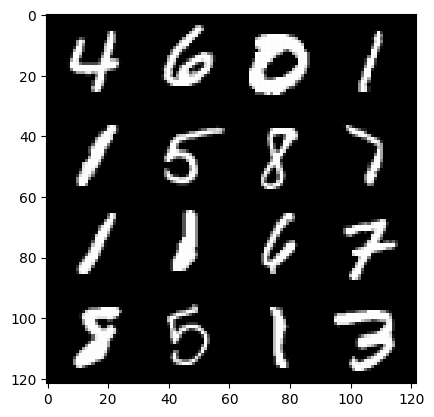

Epoch = 1361 cur_step = 166495 disc_loss = 0.29834876155802437 gen_loss = 2.0362887041401
Saving Checkpoint: 166850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 168025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

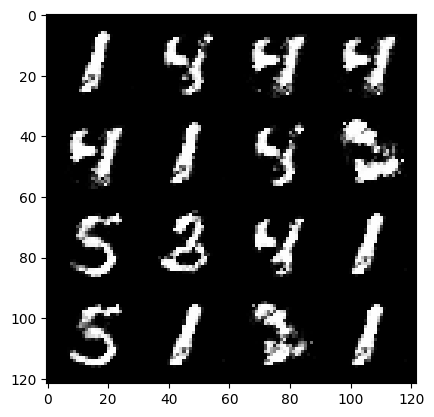

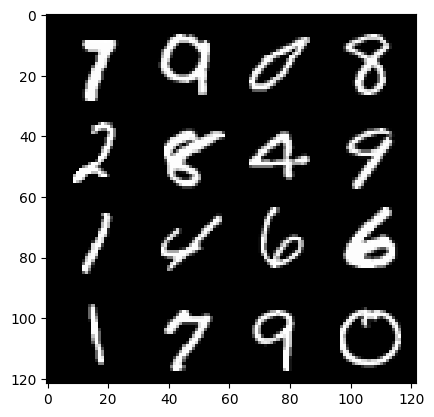

Epoch = 1366 cur_step = 168840 disc_loss = 0.29826788637938023 gen_loss = 1.9698090894390017
Saving Checkpoint: 169200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 170375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

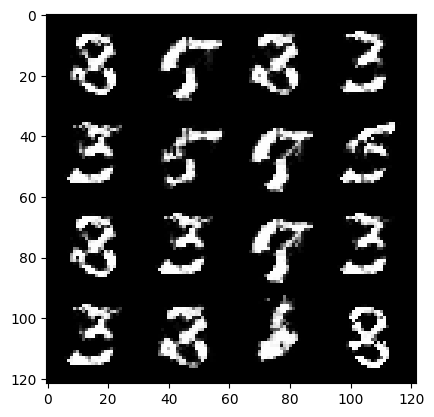

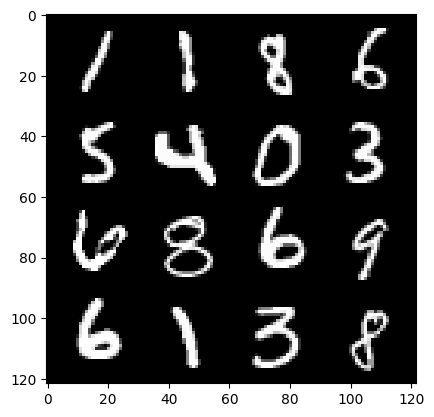

Epoch = 1371 cur_step = 171185 disc_loss = 0.33382630465127255 gen_loss = 1.8123622308153589
Saving Checkpoint: 171550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 172725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

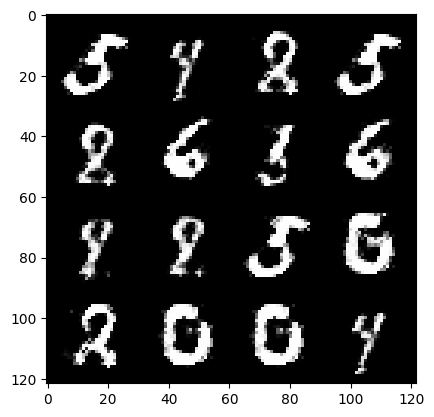

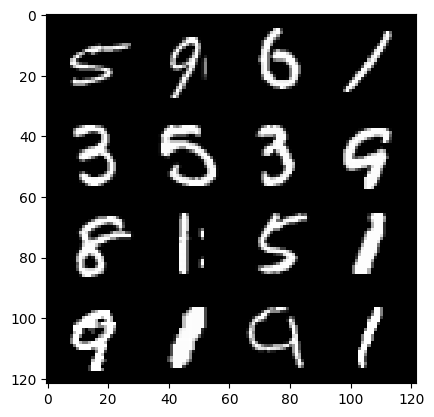

Epoch = 1376 cur_step = 173530 disc_loss = 0.3332718301111701 gen_loss = 1.8139752157207236
Saving Checkpoint: 173900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 175075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

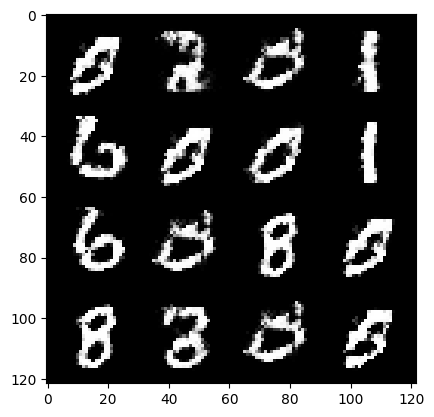

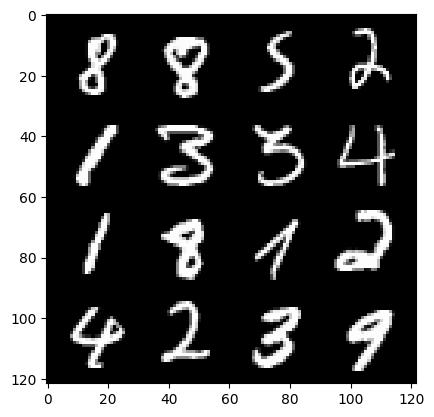

Epoch = 1381 cur_step = 175875 disc_loss = 0.3261064753095224 gen_loss = 1.8206169022171736
Saving Checkpoint: 176250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 177425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

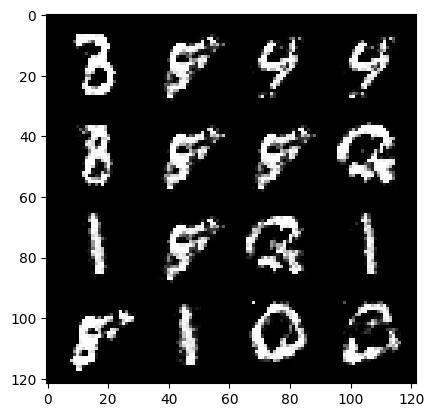

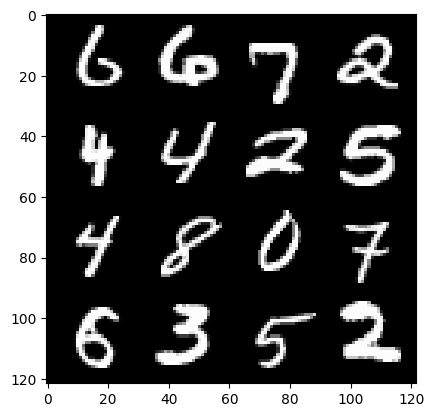

Epoch = 1386 cur_step = 178220 disc_loss = 0.3359086210031245 gen_loss = 1.855146200621306
Saving Checkpoint: 178600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 179775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

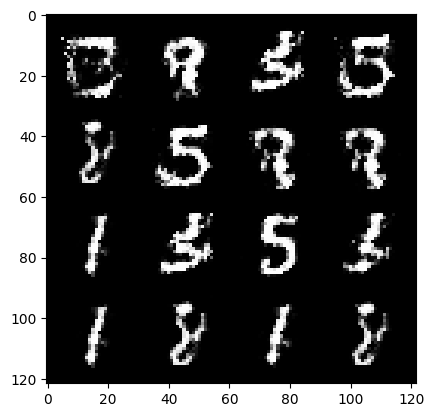

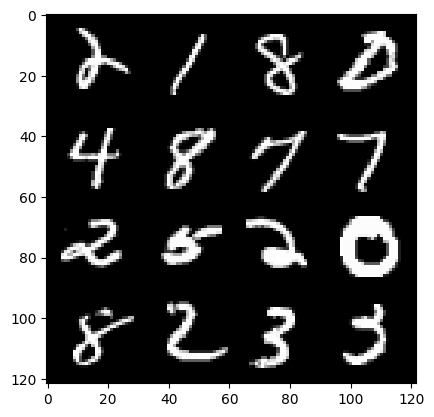

Epoch = 1391 cur_step = 180565 disc_loss = 0.3090003863644244 gen_loss = 1.9282244978174725
Saving Checkpoint: 180950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 182125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

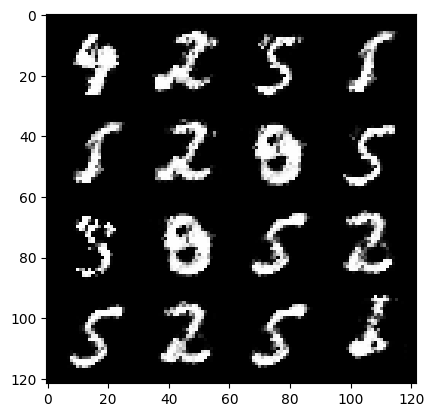

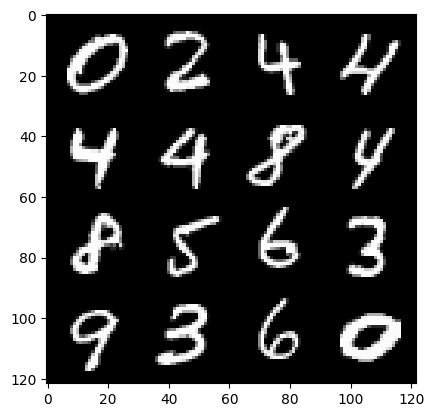

Epoch = 1396 cur_step = 182910 disc_loss = 0.30531974057081157 gen_loss = 1.9775992171850794
Saving Checkpoint: 183300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 184475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

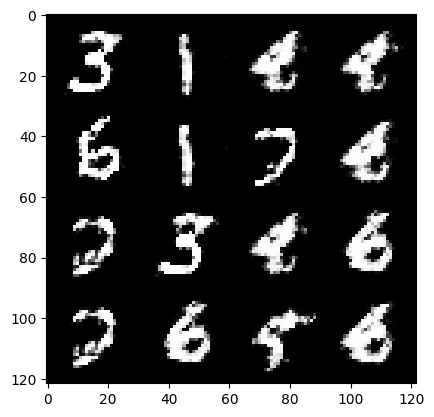

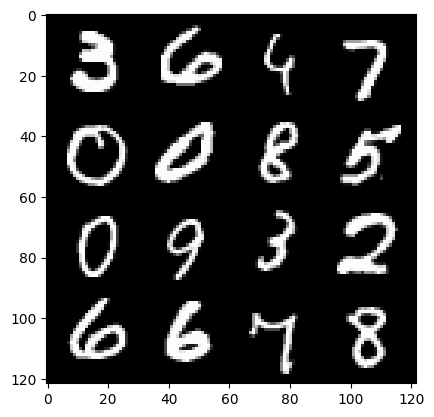

Epoch = 1401 cur_step = 185255 disc_loss = 0.29120236259025295 gen_loss = 1.977636557398066
Saving Checkpoint: 185650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 186825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

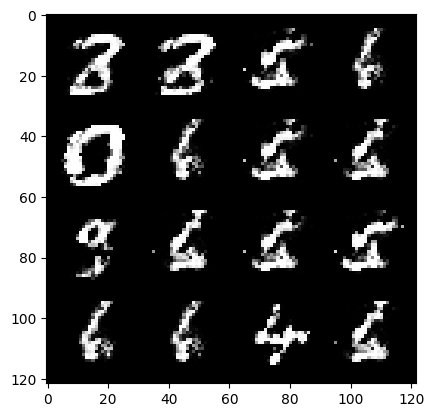

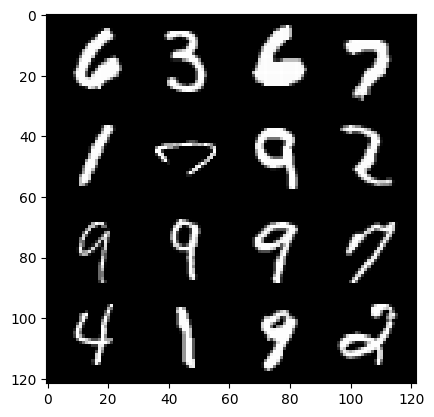

Epoch = 1406 cur_step = 187600 disc_loss = 0.3295435095011298 gen_loss = 1.8390648558704075
Saving Checkpoint: 188000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 189175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

for epoch in range(1006, epochs+1006):
    for real_img, labels in tqdm(dataloader):
        
        cur_bs = len(real_img)
        real_img = real_img.view(cur_bs, -1)
        
        ### Discrimnator
        disc_opt.zero_grad()
        real_img = real_img.to(device)
        
        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real_img, z_dim)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        ### Generator
        gen_opt.zero_grad()
        
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        ### visualisation & stats
        mean_disc_loss += disc_loss.item()
        mean_gen_loss += gen_loss.item()
        
        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise( cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake, wandbactive=1 , name='fake')
            show(real_img, wandbactive=1 , name='real')
            print("Epoch =",epoch,"cur_step =",cur_step, "disc_loss =",mean_disc_loss/info_step, "gen_loss =",mean_gen_loss/info_step  )
            mean_gen_loss = 0
            mean_disc_loss = 0

        if cur_step % save_steps == 0 and cur_step > 0:
            print("Saving Checkpoint:", cur_step)
            save_checkpoint("NumGEN-MNIST", save_path)

        if wandbact == 1:
            wandb.log({'Epoch' : epoch, 'Step' : cur_step, "Critic_Loss" : disc_loss, "Gen_Loss" : gen_loss })
            
        cur_step += 1

In [ ]:

save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
save_checkpoint("NumGEN-MNIST", save_path)

Saved Checkpoint
